In [3]:
import os
os.environ["RUNFILES_DIR"] = "/usr/local/share/plaidml"
os.environ["PLAIDML_NATIVE_PATH"] = "/usr/local/lib/libplaidml.dylib"

import plaidml.keras
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import cv2
from keras.layers  import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers, Input, layers, utils
from keras import backend as K

import numpy as np
import pandas as pd
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
from sklearn.model_selection import train_test_split
import math
import glob
import time
from matplotlib import pyplot as plt
%matplotlib inline

from skimage.metrics import structural_similarity as ssim

## Loading the data

In [4]:
# Store the list of Nifti files located in the folder specified
ff = glob.glob('/Users/fran/Downloads/IXI Dataset/IXI-T1/*')

# Show the number of items of the list
print("Number of samples:",len(ff))

Number of samples: 581


In [5]:
# Initialise the list of slices that compose every 3D Nifti file
images = []

In [9]:
# Image size 
img_size = 64
low_img_size = 32 #for super-resolution

In [10]:
# Dataset size (up to 581)
dataset_size = len(ff)

# Train-validation share
train_share = 0.8
train_size = round(dataset_size * train_share)
test_size = dataset_size - train_size
print (train_size, test_size)

465 116


In [11]:
# Split the data (images) between train and validation data
# Split by MRI, to avoid using slices from the same subject
# in both training and validation sets
train_masked, test_masked, train_original, test_original = train_test_split(ff[0:dataset_size],
                                                             ff[0:dataset_size],
                                                             test_size = 1 - train_share,
                                                             random_state = 13)

In [12]:
# Functions to extract the slices of the MRI (one per axis)
# To use other slices range, replace the values in a

# Transverse view
# Load only the middle 51 slices of the brain
def load_nifti(input):
    print ("Processing images ", end="", flush=True)
    images = []
    for f in range(len(input)): 
    # Using a subset of 50 Nifti files
        a = nib.load(input[f])
        a = a.get_fdata()
        a = a[:,103:154,:]
        print (". ", end="", flush=True)
        for i in range(a.shape[1]):
            b = a[:,i,:]
            b = cv2.resize(b, dsize=(img_size,img_size), interpolation=cv2.INTER_CUBIC)
            images.append(b)
    print (" Done." , f+1, "images processed.", end="", flush=True)
    # Using numpy to convert the list into a numpy array
    images = np.asarray(images)
    # Reshape the array to a matrix of size img_sizeximg_sizex1
    images = images.reshape(-1,img_size,img_size,1)
    # Rescaling the data using max-min normalisation technique
    m = np.max(images)
    mi = np.min(images)
    images = (images - mi) / (m - mi)
    return images

# Load only the middle 51 slices of the brain
def load_nifti_lat(input):
    print ("Processing images ", end="", flush=True)
    images = []
    for f in range(len(input)): 
    # Using a subset of 50 Nifti files
        a = nib.load(ff[f])
        a = a.get_fdata()
        a = a[:,:,75:126]
        print (". ", end="", flush=True)
        for i in range(a.shape[2]):
            a = cv2.resize(a, dsize=(img_size,img_size), interpolation=cv2.INTER_CUBIC)
            images.append((a[:,:,i]))
    print (" Done." , f+1, "images processed.", end="", flush=True)
    # Using numpy to convert the list into a numpy array
    images = np.asarray(images)
    # Reshape the array to a matrix of size img_sizeximg_sizex1
    images = images.reshape(-1,img_size,img_size,1)
    # Rescaling the data using max-min normalisation technique
    m = np.max(images)
    mi = np.min(images)
    images = (images - mi) / (m - mi)
    return images

# Sagittal view
# Load only the middle 51 slices of the brain
def load_nifti_f(input):
    print ("Processing images ", end="", flush=True)
    images = []
    for f in range(len(input)): 
        a = nib.load(input[f])
        a = a.get_fdata()
        a = a[103:154,:,:]
        print (". ", end="", flush=True)
        for i in range(a.shape[0]):
            b = a[i,:,:]
            b = cv2.resize(b, dsize=(img_size,img_size), interpolation=cv2.INTER_CUBIC)
            images.append(b)
    print (" Done." , f+1, "images processed.", end="", flush=True)
    # Using numpy to convert the list into a numpy array
    images = np.asarray(images)
    # Reshape the array to a matrix of size img_sizeximg_sizex1
    images = images.reshape(-1,img_size,img_size,1)
    # Rescaling the data using max-min normalisation technique
    m = np.max(images)
    mi = np.min(images)
    images = (images - mi) / (m - mi)
    return images

In [13]:
# Extracting the slices from the train dataset
# transverse axis
train_original = load_nifti(train_original)

Processing images . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .  Done. 464 images processed.

In [14]:
# Extracting the slices from the validation dataset
# transverse axis
test_original = load_nifti(test_original)

Processing images . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .  Done. 117 images processed.

## Data Preprocessing

In [15]:
# Function to create a random mask for a slice to train the model:
# returns the masked image, and the coordinates and thickness of the mask
def createMask(img):
    ## Prepare masking matrix
    mask = np.full((img_size, img_size), 0, np.float32)
    for _ in range(np.random.randint(1, 2)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(img_size*0.3, img_size*0.7), np.random.randint(img_size*0.3, img_size*0.7)
      # Get random y locations to start line
      y1, y2 = np.random.randint(img_size*0.3, img_size*0.7), np.random.randint(img_size*0.3, img_size*0.7)
      # Get random thickness of the line drawn
      thickness = np.random.randint(2, img_size/8)
      # Draw line on the mask
      opacity = np.random.randint(1,8)*0.1
      cv2.line(mask,(x1,y1),(x2,y2),(opacity, opacity, opacity),thickness)
    #plt.imshow(mask,cmap='gray')
    #plt.show()
    # Perforn bitwise and operation to mask the image
    max_patch = np.max(img) # para que la mascara no desature el resto
    masked_image = img + mask
    masked_image = np.minimum(max_patch, masked_image)
    return masked_image, x1, x2, y1, y2, thickness

# https://users.fmrib.ox.ac.uk/~saad/ONBI/ONBI-Fourier_Practical_python.html
# Function to add Gibb's ringing noise to a slice to train the model:
# returns the noisy image
def addGibb(img, value=0.1):
    ## Prepare masking matrix
    data = (np.fft.fft2(img))
    K = data [:, int(img_size/2-img_size/(2+value)):int(img_size/2+img_size/(2+value))]
    gibb = np.fft.ifft2(K, s=[img_size, img_size])
    gibb = np.abs(gibb[:,:,0])  
    return gibb

# Function to add ghosting noise to a slice to train the model:
# returns the noisy image
def addGhost(img, value=0):
    ## Prepare masking matrix
    data = (np.fft.fft2(img))
    K = data [:, int(img_size/2-img_size/(2+value)):int(img_size/2+img_size/(2+value))]
    K[::2,:] = 0.7*K[::2,:]
    ghost = np.fft.ifft2(K)
    ghost = np.abs(ghost[:,:,0])  
    return ghost

In [16]:
# Function to return the patch coordinates of an image
def patch_loc(mask_train, img_example):
    x_start = np.min((mask_train[img_example,0], mask_train[img_example,1]))-mask_train[img_example,4]
    y_start = np.min((mask_train[img_example,2], mask_train[img_example,3]))-mask_train[img_example,4]
    x_len = abs(mask_train[img_example,0] - mask_train[img_example,1])+2*mask_train[img_example,4]
    y_len = abs(mask_train[img_example,2] - mask_train[img_example,3])+2*mask_train[img_example,4]
    return (x_start, y_start, x_len, y_len)

In [17]:
# Use of the different masking and noise functions
# throughout the train and validation dataset

train_masked = [] # Array for masked images
train_masked_loc = [] # Array for masks coordinates
test_masked = []
test_masked_loc = []

# Loop the masking function through the dataset
for f in range(len(train_original)):
    gibb = addGibb(train_original[f,:,:])
    mask = createMask(gibb)
    train_masked.append(mask[0])
    masked_loc = (mask[1], mask[2], mask[3], mask[4], mask[5]) 
    train_masked_loc.append(masked_loc)
for f in range(len(train_original)):    
    ghost = addGhost(train_original[f,:,:])
    mask = createMask(ghost)
    train_masked.append(mask[0])
    masked_loc = (mask[1], mask[2], mask[3], mask[4], mask[5]) 
    train_masked_loc.append(masked_loc)
for f in range(len(train_original)):
    mask = createMask(train_original[f,:,:,0])
    masked_pic = mask[0]
    masked_pic = cv2.resize(masked_pic, dsize=(low_img_size,low_img_size), interpolation=cv2.INTER_CUBIC)
    masked_pic = cv2.resize(masked_pic, dsize=(img_size,img_size), interpolation=cv2.INTER_NEAREST)
    masked_loc = (mask[1], mask[2], mask[3], mask[4], mask[5]) 
    train_masked.append(masked_pic)
    train_masked_loc.append(masked_loc)

# Loop the masking function through the dataset
for f in range(len(test_original)):
    gibb = addGibb(test_original[f,:,:])
    mask = createMask(gibb)
    test_masked.append(mask[0])
    masked_loc = (mask[1], mask[2], mask[3], mask[4], mask[5]) 
    test_masked_loc.append(masked_loc)
for f in range(len(test_original)):    
    ghost = addGhost(test_original[f,:,:])
    mask = createMask(ghost)
    test_masked.append(mask[0])
    masked_loc = (mask[1], mask[2], mask[3], mask[4], mask[5]) 
    test_masked_loc.append(masked_loc)
for f in range(len(test_original)):
    mask = createMask(test_original[f,:,:,0])
    masked_pic = mask[0]
    masked_pic = cv2.resize(masked_pic, dsize=(low_img_size,low_img_size), interpolation=cv2.INTER_CUBIC)
    masked_pic = cv2.resize(masked_pic, dsize=(img_size,img_size), interpolation=cv2.INTER_NEAREST)
    masked_loc = (mask[1], mask[2], mask[3], mask[4], mask[5]) 
    test_masked.append(masked_pic)
    test_masked_loc.append(masked_loc)

# Convert the output to array and reshape to the input expected by the network
train_masked = np.asarray(train_masked)
test_masked = np.asarray(test_masked)
train_masked = np.reshape(train_masked,(-1, img_size, img_size, 1))
test_masked = np.reshape(test_masked,(-1, img_size, img_size, 1))

# Convert the mask coordinates to array
train_masked_loc = np.asarray(train_masked_loc)
test_masked_loc = np.asarray(test_masked_loc)


In [18]:
# Triplicate the ground true values to compare with gibb and ghosting
train_triple = np.append(train_original, train_original, axis=0)
train_original = np.append(train_original, train_triple, axis=0)
test_triple = np.append(test_original, test_original, axis=0)
test_original = np.append(test_original, test_triple, axis=0)

In [19]:
# Shuffle slices
np.random.seed(13)
np.random.shuffle(train_original)
np.random.seed(13)
np.random.shuffle(test_original)
np.random.seed(13)
np.random.shuffle(train_masked)
np.random.seed(13)
np.random.shuffle(test_masked)
np.random.seed(13)
np.random.shuffle(train_masked_loc)
np.random.seed(13)
np.random.shuffle(test_masked_loc)

## Data exploration

In [20]:
# Shapes of training set
print("Dataset (images) shape: {shape}".format(shape=train_masked.shape))

Dataset (images) shape: (70992, 64, 64, 1)


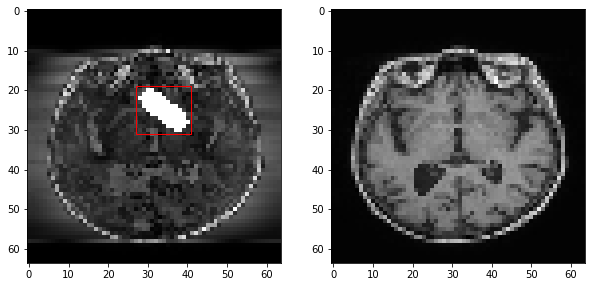

In [21]:
# Show a sample of the input and expected output data

img_example = 51
plt.figure(figsize=[10,10])

# Get patch location and size
x_start, y_start, x_len, y_len = patch_loc(train_masked_loc,img_example)

# Display a masked image in training data
plt.subplot(121)
curr_img = np.reshape(train_masked[img_example], (img_size,img_size))
plt.gca().add_patch(plt.Rectangle((x_start, y_start), x_len, y_len, fc='none', ec='red'))
plt.imshow(curr_img, cmap='gray')

# Display the original image
plt.subplot(122)
curr_img = np.reshape(train_original[img_example], (img_size,img_size))
plt.imshow(curr_img, cmap='gray')

## MODELS
### U-NET 
https://github.com/Muthu2093/U-Net-for-Brain-Tumor-Segmentation/blob/master/code-python3/unet3d.py

In [30]:
# Class to show the progress of the network by predicting every x epochs
class show_result_Callback(Callback):
    epoch_pred = 1
    pred=[]    
    b=13
    def on_train_begin(self, logs=None): 
        plt.figure(figsize=(20, 4))
        print("Test Images")
        for i in range(5):
            # Get patch location and size
            x_start, y_start, x_len, y_len = patch_loc(test_masked_loc,self.b+i)
            plt.subplot(1, 5, i+1)
            plt.gca().add_patch(plt.Rectangle((x_start, y_start), x_len, y_len, fc='none', ec='red'))
            plt.imshow(test_masked[i+self.b, ..., 0], cmap='gray')
        fname = "input_" + str(time.time())+ ".png"
        plt.savefig(fname)
        plt.show()    

    def on_epoch_end(self, epochs, logs=None):
        if (epochs % self.epoch_pred == 0):
            self.pred = model.predict(test_masked) 
            plt.figure(figsize=(20, 4))
            print("Reconstruction of Test Images: epoch", epochs)
            for i in range(5):
                plt.subplot(1, 5, i+1)
                plt.imshow(self.pred[i+self.b, ..., 0], cmap='gray')
            fname = "result_" + str(epochs) + "_" + str(time.time())+ ".png"
            plt.savefig(fname)  
            plt.show()
            psn=[]
            mse=[]
            ssi=[]
            for i in range(len(self.pred)):
                i1 = test_original[i, ..., 0].reshape(img_size*img_size)
                i2 = self.pred[i, ..., 0].reshape(img_size*img_size)
                psn.append(cv2.PSNR(np.float32(i1), np.float32(i2), 1))
                mse.append(np.square(np.subtract(i1, i2).mean()))
                ssi.append(ssim(i1, i2, data_range=i2.max() - i2.min()))
            print("PSNR pictures:",np.average(psn))
            print("MSE pictures", np.average(mse))
            print("SSIM pictures",np.average(ssi))
            psnr_result.append(np.average(psn))
            mse_result.append(np.average(mse))
            ssim_result.append(np.average(ssi))

            psnp=[]
            msep=[]
            ssip=[]
            for i in range(len(self.pred)):
                x_start, y_start, x_len, y_len = patch_loc(test_masked_loc,i)
                i1 = test_original[i, y_start:y_start+y_len, x_start:x_start+x_len, 0].reshape(y_len*x_len)
                i2 = self.pred[i, y_start:y_start+y_len, x_start:x_start+x_len, 0].reshape(y_len*x_len)
                psnp.append(cv2.PSNR(np.float32(i1), np.float32(i2), 1))
                msep.append(np.square(np.subtract(i1, i2).mean()))
                ssip.append(ssim(i1, i2, data_range=i2.max() - i2.min()))
            print("PSNR patches:",np.average(psnp))
            print("MSE patches", np.average(msep))
            print("SSIM patches",np.average(ssip))
            psnrp_result.append(np.average(psnp))
            msep_result.append(np.average(msep))
            ssimp_result.append(np.average(ssip))

            np.savetxt('ssim.csv', ssim_result)
            np.savetxt('ssimp.csv', ssimp_result)
            np.savetxt('psnr.csv', psnr_result)
            np.savetxt('psnrp.csv', psnrp_result)
            np.savetxt('mse.csv', mse_result)
            np.savetxt('msep.csv', msep_result)


    def on_train_end(self, logs=None):
        plt.figure(figsize=(20, 4))
        print("Original Images")
        for i in range(5):
            plt.subplot(1, 5, i+1)
            plt.imshow(test_original[i+self.b, ..., 0], cmap='gray') 
        fname = "original_" + str(time.time())+ ".png"
        plt.savefig(fname)
        plt.show()

        pic_diff = test_original[self.b:self.b+5,:,:] - self.pred[self.b:self.b+5,:,:]
        max_color = np.max(pic_diff[0:5,:,:])

        plt.figure(figsize=(20, 4))
        print("Difference")
        for i in range(5):
            plt.subplot(1, 5, i+1)
            plt.imshow(pic_diff[i, ..., 0], cmap='Reds', vmin=0, vmax=max_color)
            plt.colorbar()
        fname = "difference_" + str(time.time())+ ".png"
        plt.savefig(fname)
        plt.show()

In [23]:
# U-net model modified with an output relu activation layer (instead of sigmoid). The original net
# was intended for segmentation problems; this one is for inpainting.
def Unet_model():
        inputs = Input((img_size, img_size, 1))
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

        up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
        merge6 = concatenate([conv4,up6], axis = 3)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = concatenate([conv3,up7], axis = 3)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        merge8 = concatenate([conv2,up8], axis = 3)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

        up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 = concatenate([conv1,up9], axis = 3)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv9 = Conv2D(1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

        model = Model(inputs = inputs, outputs = conv9)
        
        return model

In [24]:
# Clear Keras session
K.clear_session()

In [25]:
# Load the model
model = Unet_model()

INFO:plaidml:Opening device "metal_amd_radeon_pro_5300m.0"


In [26]:
# Compile the model
model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_squared_error')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [27]:
# Arrays to store the metrics results after each epoch
# for the slices
psnr_result = []
ssim_result = []
mse_result = []
# And the patches
psnrp_result = []
ssimp_result = []
msep_result = []

In [40]:
# Storage of the model
model_checkpoint = ModelCheckpoint(filepath='unet_augmented_32_amd_top_50_{epoch:02d}.h5', monitor='loss',verbose=1, save_best_only=False, period=1)

Train on 70992 samples, validate on 17901 samples
Test Images


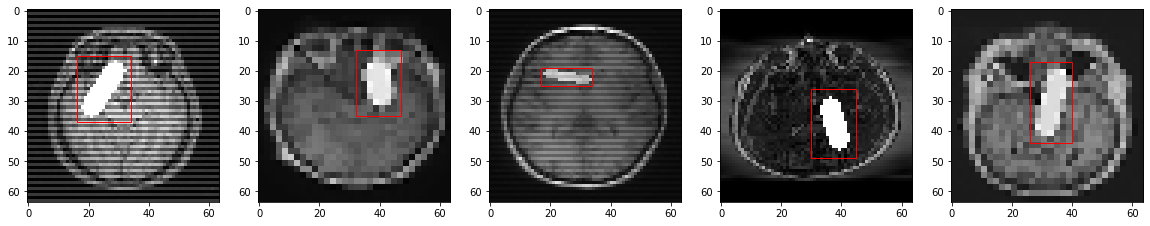

Epoch 1/10


INFO:plaidml:Analyzing Ops: 375 of 917 operations complete


70992/70992 [==============================] - 3537s 50ms/step - loss: 2.6382e-04 - val_loss: 1.3956e-04

Epoch 00001: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_01_.h5
Reconstruction of Test Images: epoch 0


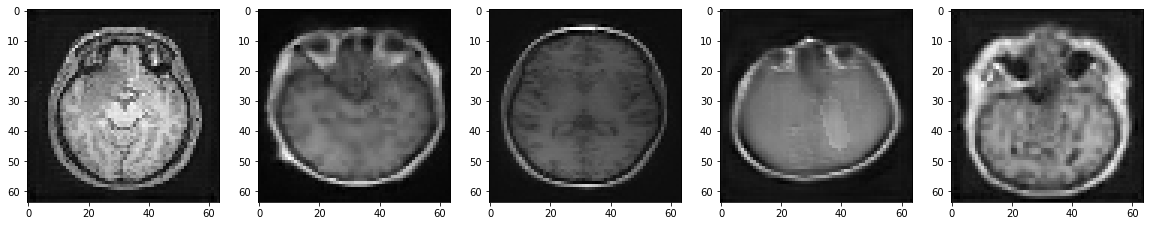

PSNR pictures: 44.846297593680035
MSE pictures 1.574177520523392e-05
SSIM pictures 0.7637575057155476
PSNR patches: 39.3904660571932
MSE patches 7.303182924948467e-05
SSIM patches 0.35551582251808383
Epoch 2/10
70992/70992 [==============================] - 3521s 50ms/step - loss: 1.1871e-04 - val_loss: 8.7126e-05

Epoch 00002: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_02_.h5
Reconstruction of Test Images: epoch 1


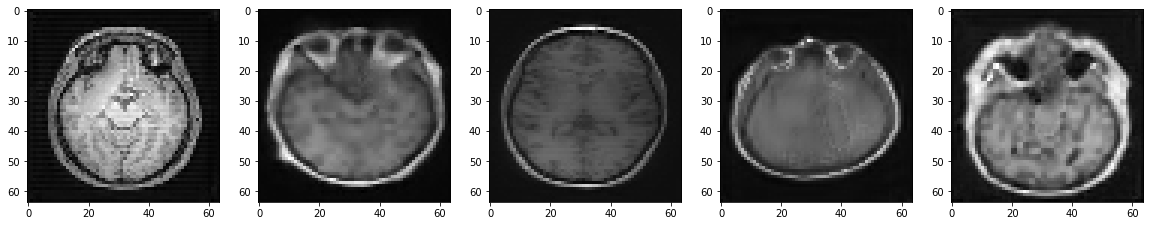

PSNR pictures: 45.374406029170366
MSE pictures 6.933911694695325e-06
SSIM pictures 0.8190477296119032
PSNR patches: 39.97699097183645
MSE patches 4.280290446969991e-05
SSIM patches 0.4241966167680261
Epoch 3/10
70992/70992 [==============================] - 3527s 50ms/step - loss: 8.7906e-05 - val_loss: 6.7166e-05

Epoch 00003: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_03_.h5
Reconstruction of Test Images: epoch 2


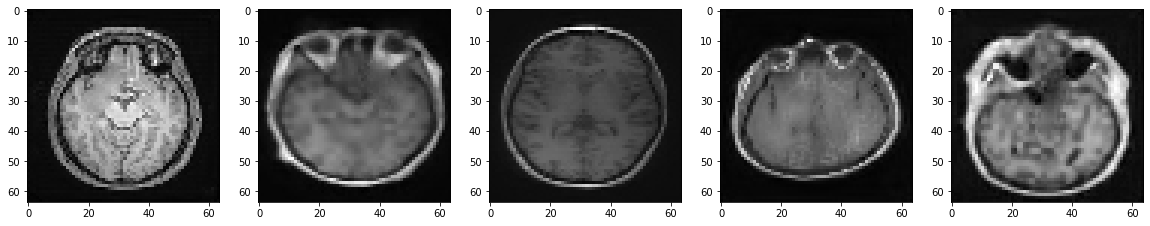

PSNR pictures: 47.66113598716042
MSE pictures 1.354589148019365e-06
SSIM pictures 0.850664190616442
PSNR patches: 41.49343647194285
MSE patches 1.976875524732814e-05
SSIM patches 0.48043777508868357
Epoch 4/10
70992/70992 [==============================] - 3528s 50ms/step - loss: 7.3471e-05 - val_loss: 6.4161e-05

Epoch 00004: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_04_.h5
Reconstruction of Test Images: epoch 3


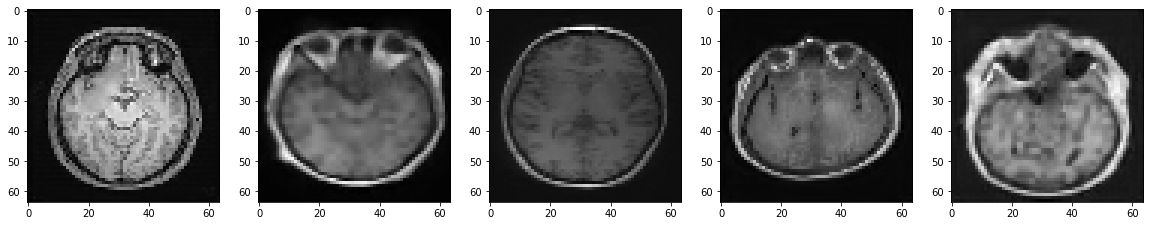

PSNR pictures: 47.653190807730404
MSE pictures 2.7628928140695772e-06
SSIM pictures 0.8617620414093514
PSNR patches: 41.72425391358292
MSE patches 1.6595747505967026e-05
SSIM patches 0.5080321078528055
Epoch 5/10
70992/70992 [==============================] - 3523s 50ms/step - loss: 6.5027e-05 - val_loss: 6.4820e-05

Epoch 00005: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_05_.h5
Reconstruction of Test Images: epoch 4


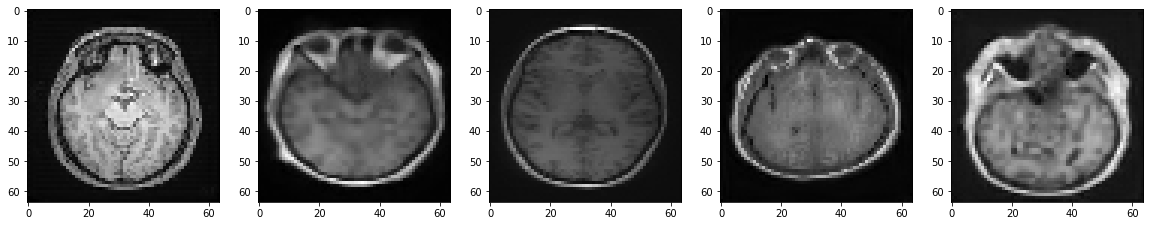

PSNR pictures: 46.98646910449311
MSE pictures 4.221984162914136e-06
SSIM pictures 0.8585714673945739
PSNR patches: 41.76800647176338
MSE patches 2.1029237937870258e-05
SSIM patches 0.5084106023482722
Epoch 6/10
70992/70992 [==============================] - 3522s 50ms/step - loss: 5.9599e-05 - val_loss: 6.1184e-05

Epoch 00006: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_06_.h5
Reconstruction of Test Images: epoch 5


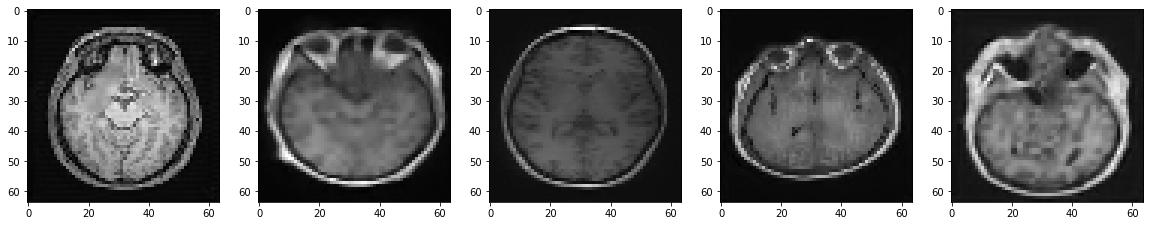

PSNR pictures: 46.6645119166981
MSE pictures 5.586906531568046e-06
SSIM pictures 0.8681935664337977
PSNR patches: 41.68111362420656
MSE patches 1.9203125637922e-05
SSIM patches 0.5339359744179186
Epoch 7/10
70992/70992 [==============================] - 3522s 50ms/step - loss: 5.5052e-05 - val_loss: 5.3319e-05

Epoch 00007: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_07_.h5
Reconstruction of Test Images: epoch 6


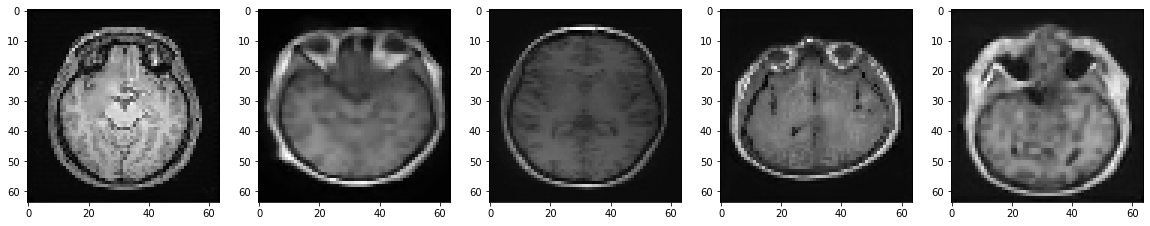

PSNR pictures: 48.728342094794485
MSE pictures 1.9261411742171565e-06
SSIM pictures 0.8804535156496673
PSNR patches: 42.370460132580554
MSE patches 1.2002608985404459e-05
SSIM patches 0.5551712749649671
Epoch 8/10
70992/70992 [==============================] - 3523s 50ms/step - loss: 5.2016e-05 - val_loss: 5.4251e-05

Epoch 00008: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_08_.h5
Reconstruction of Test Images: epoch 7


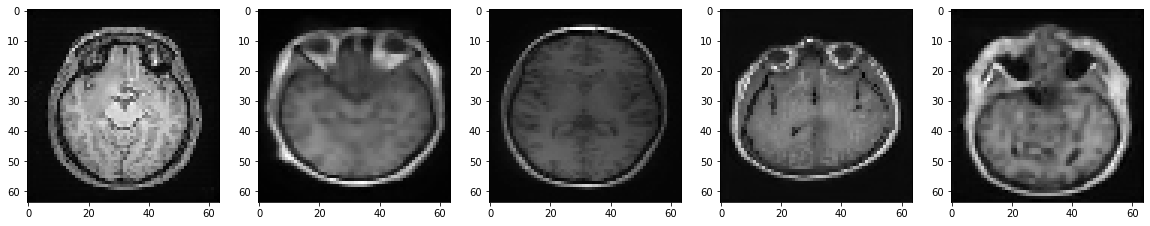

PSNR pictures: 48.618610938136975
MSE pictures 3.222758516774882e-06
SSIM pictures 0.8819042149856987
PSNR patches: 42.441528622821366
MSE patches 1.5811549860487706e-05
SSIM patches 0.5664312367075113
Epoch 9/10
70992/70992 [==============================] - 3520s 50ms/step - loss: 4.9272e-05 - val_loss: 5.2969e-05

Epoch 00009: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_09_.h5
Reconstruction of Test Images: epoch 8


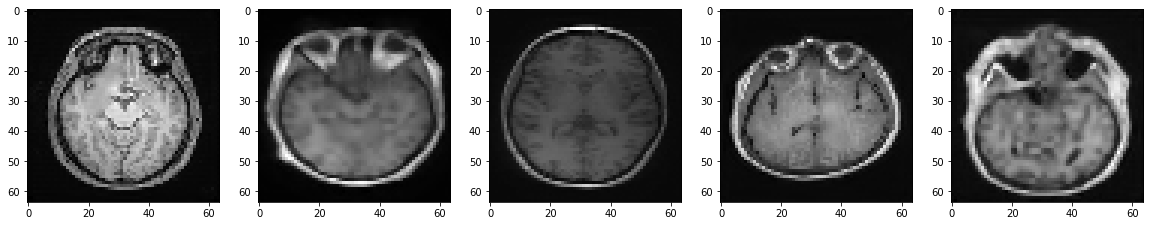

PSNR pictures: 48.98754529065492
MSE pictures 2.243712365417692e-06
SSIM pictures 0.8851406664744195
PSNR patches: 42.673140408401814
MSE patches 1.4148405858417184e-05
SSIM patches 0.5722300265720733
Epoch 10/10
70992/70992 [==============================] - 3516s 50ms/step - loss: 4.6469e-05 - val_loss: 5.2869e-05

Epoch 00010: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_10_.h5
Reconstruction of Test Images: epoch 9


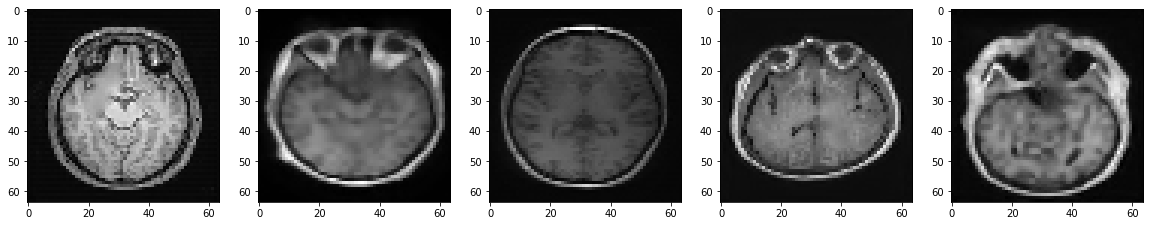

PSNR pictures: 48.40247452741322
MSE pictures 3.2325855564715766e-06
SSIM pictures 0.8879782673849373
PSNR patches: 42.627190128264715
MSE patches 1.6595010523374994e-05
SSIM patches 0.5820833808443364
Original Images


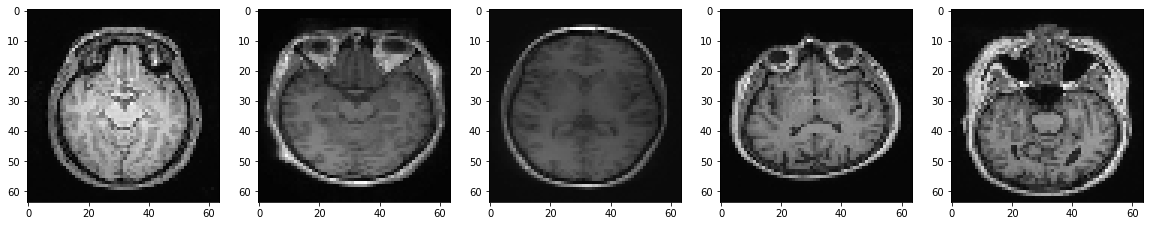

Difference


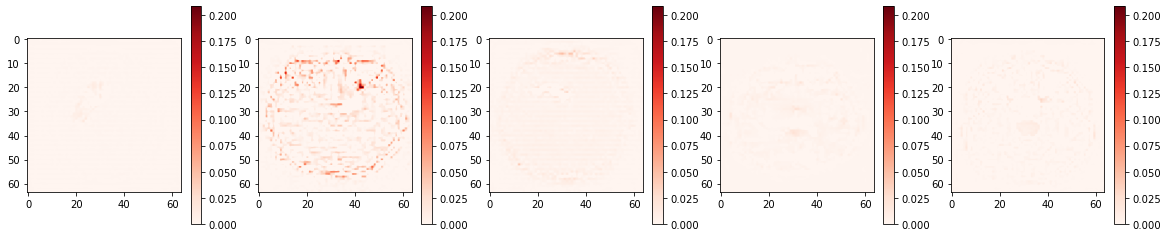

In [31]:
# Train the model
history = model.fit(train_masked, train_original, validation_data=(test_masked, test_original), epochs=10, batch_size=8, verbose=1, callbacks=[model_checkpoint,show_result_Callback()])

Train on 70992 samples, validate on 17901 samples
Test Images


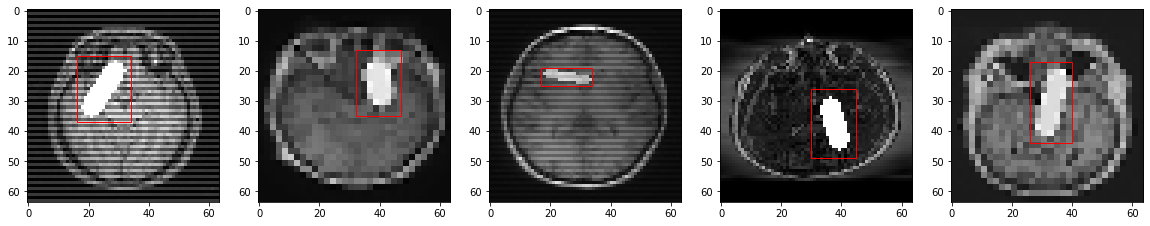

Epoch 1/10
70992/70992 [==============================] - 3527s 50ms/step - loss: 4.4395e-05 - val_loss: 5.2297e-05

Epoch 00001: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_01_.h5
Reconstruction of Test Images: epoch 0


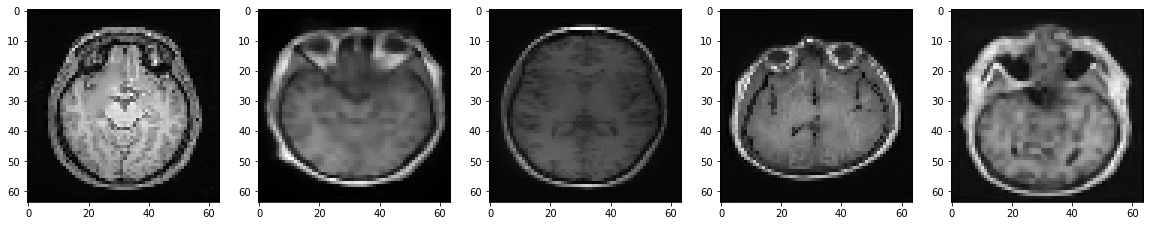

PSNR pictures: 48.92055720604371
MSE pictures 2.7414391542583045e-06
SSIM pictures 0.8876355310796532
PSNR patches: 42.60827512049775
MSE patches 1.6551321743596725e-05
SSIM patches 0.5835697770983647
Epoch 2/10
70992/70992 [==============================] - 3519s 50ms/step - loss: 4.2338e-05 - val_loss: 5.0653e-05

Epoch 00002: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_02_.h5
Reconstruction of Test Images: epoch 1


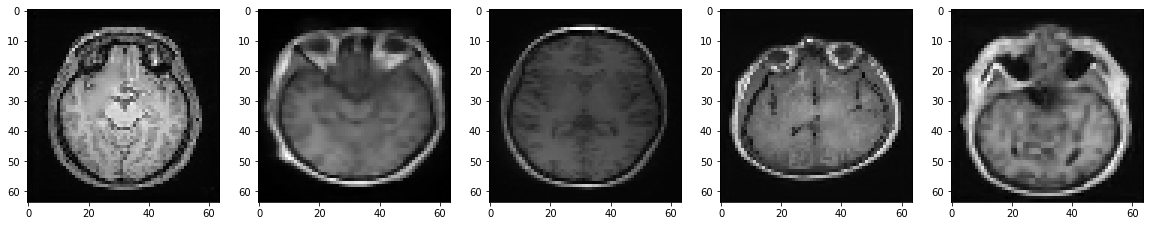

PSNR pictures: 49.187271377158076
MSE pictures 2.2291061827407474e-06
SSIM pictures 0.8903054241005152
PSNR patches: 42.80668030196629
MSE patches 1.4514579630719504e-05
SSIM patches 0.5889655448176816
Epoch 3/10
70992/70992 [==============================] - 3530s 50ms/step - loss: 4.0908e-05 - val_loss: 5.4197e-05

Epoch 00003: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_03_.h5
Reconstruction of Test Images: epoch 2


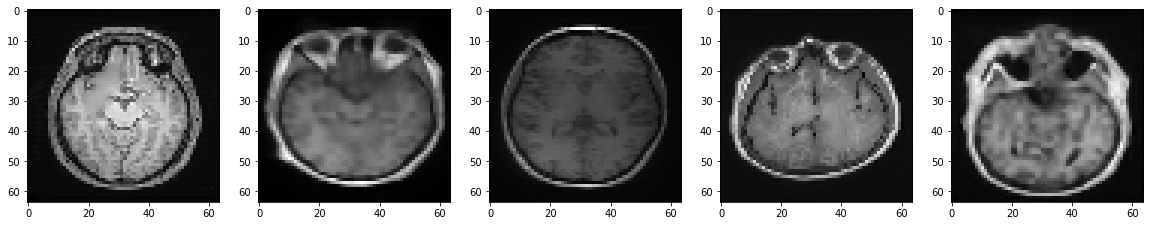

PSNR pictures: 48.74350898415256
MSE pictures 4.5012300408637355e-06
SSIM pictures 0.8899254159430953
PSNR patches: 42.66676038684133
MSE patches 2.03790684316803e-05
SSIM patches 0.5951213829920446
Epoch 4/10
70992/70992 [==============================] - 3523s 50ms/step - loss: 3.9457e-05 - val_loss: 4.9074e-05

Epoch 00004: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_04_.h5
Reconstruction of Test Images: epoch 3


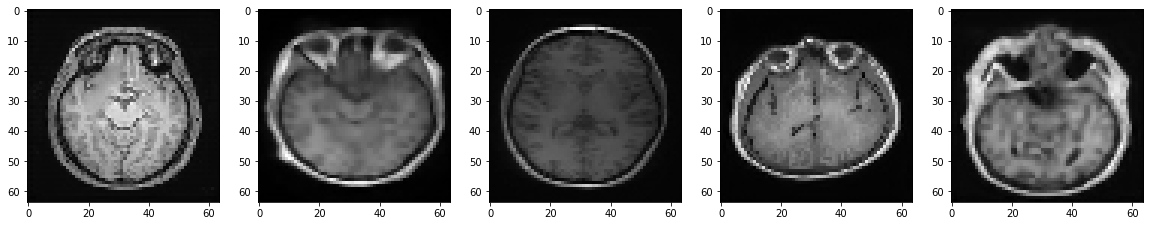

PSNR pictures: 49.3135120669328
MSE pictures 1.4407813296657598e-06
SSIM pictures 0.8926110583104094
PSNR patches: 43.072040806298396
MSE patches 9.980299354101342e-06
SSIM patches 0.5998207006311614
Epoch 5/10
70992/70992 [==============================] - 3522s 50ms/step - loss: 3.7874e-05 - val_loss: 4.9248e-05

Epoch 00005: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_05_.h5
Reconstruction of Test Images: epoch 4


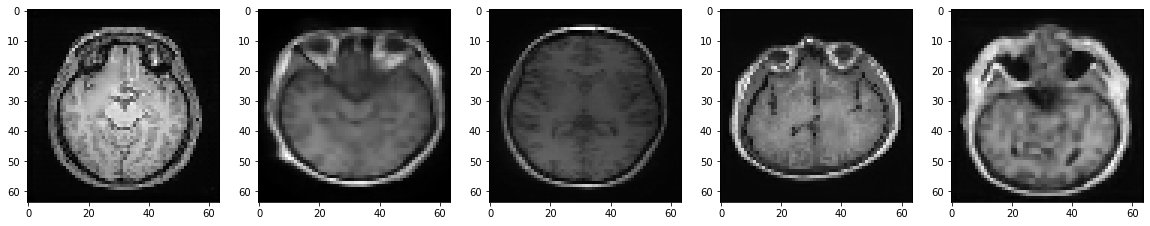

PSNR pictures: 49.37936157331663
MSE pictures 1.7417450475502218e-06
SSIM pictures 0.8948204473673869
PSNR patches: 43.024693842519675
MSE patches 1.1864802231788312e-05
SSIM patches 0.607893281474274
Epoch 6/10
70992/70992 [==============================] - 3531s 50ms/step - loss: 3.6901e-05 - val_loss: 5.1552e-05

Epoch 00006: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_06_.h5
Reconstruction of Test Images: epoch 5


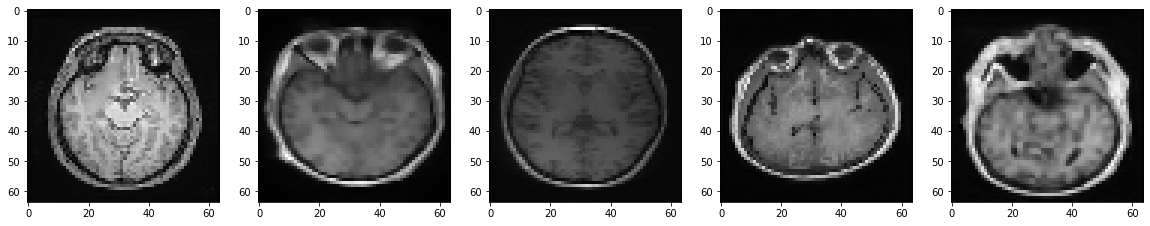

PSNR pictures: 49.435302725529894
MSE pictures 3.0356058153957302e-06
SSIM pictures 0.8949102622283361
PSNR patches: 43.05449482519471
MSE patches 1.7516734291133217e-05
SSIM patches 0.6095889553674616
Epoch 7/10
70992/70992 [==============================] - 3116s 44ms/step - loss: 3.5938e-05 - val_loss: 5.1418e-05

Epoch 00007: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_07_.h5
Reconstruction of Test Images: epoch 6


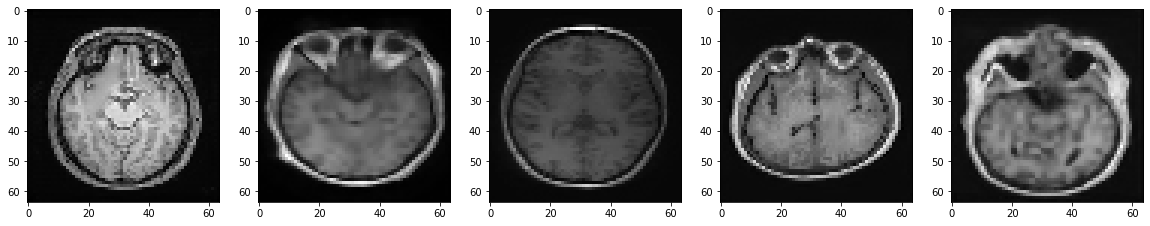

PSNR pictures: 49.45342172976589
MSE pictures 3.166441751621309e-06
SSIM pictures 0.8969233256527364
PSNR patches: 43.147342630129394
MSE patches 1.563175696748445e-05
SSIM patches 0.6166155061554471
Epoch 8/10
70992/70992 [==============================] - 3158s 44ms/step - loss: 3.4971e-05 - val_loss: 5.0647e-05

Epoch 00008: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_08_.h5
Reconstruction of Test Images: epoch 7


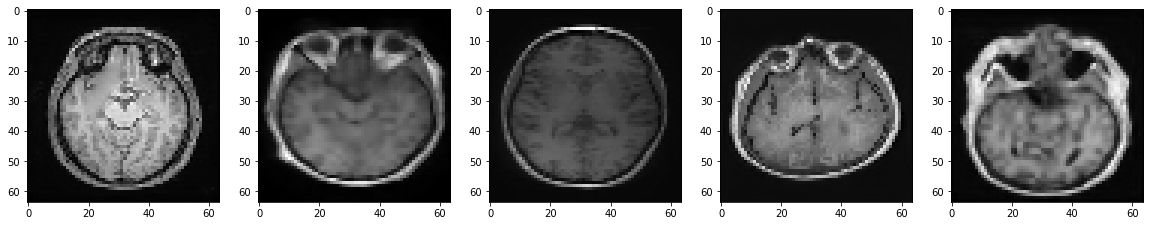

PSNR pictures: 49.52311009546333
MSE pictures 2.6468475347302284e-06
SSIM pictures 0.8969622331309702
PSNR patches: 43.131102157989574
MSE patches 1.590778537053511e-05
SSIM patches 0.6144543032541986
Epoch 9/10
70992/70992 [==============================] - 3136s 44ms/step - loss: 3.3750e-05 - val_loss: 5.0119e-05

Epoch 00009: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_09_.h5
Reconstruction of Test Images: epoch 8


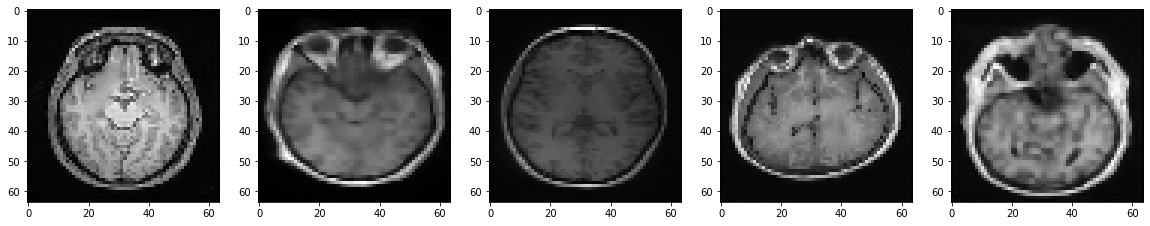

PSNR pictures: 49.656536709878786
MSE pictures 2.2524437640695916e-06
SSIM pictures 0.8975003746549373
PSNR patches: 43.298828083637034
MSE patches 1.3779867051934314e-05
SSIM patches 0.6218144343105338
Epoch 10/10
70992/70992 [==============================] - 3163s 45ms/step - loss: 3.2672e-05 - val_loss: 4.9351e-05

Epoch 00010: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_10_.h5
Reconstruction of Test Images: epoch 9


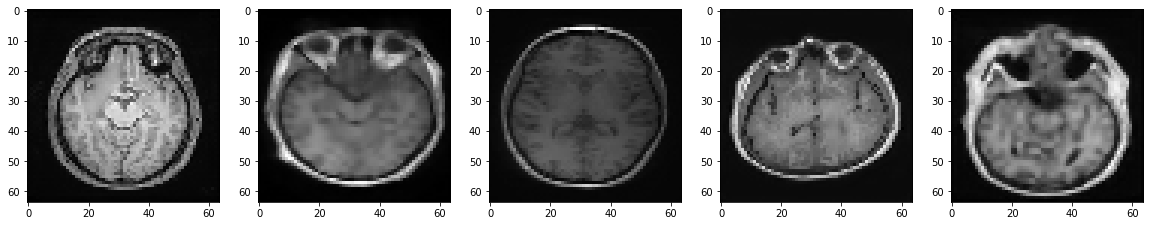

PSNR pictures: 49.36048133425344
MSE pictures 1.9367569898953045e-06
SSIM pictures 0.8969973782182697
PSNR patches: 43.183495844451016
MSE patches 1.3035258023433302e-05
SSIM patches 0.6225210265423348
Original Images


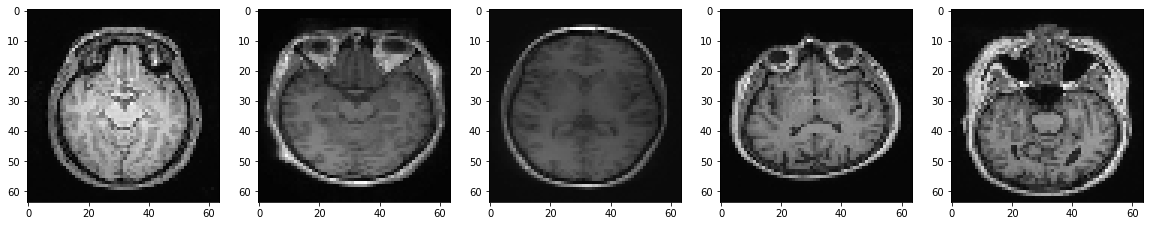

Difference


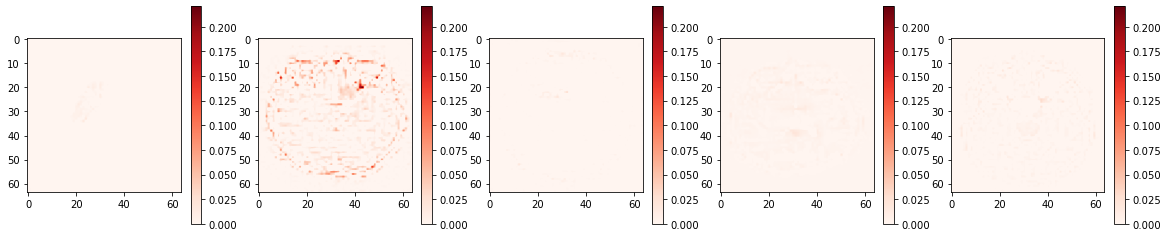

In [33]:
# Train the model
history = model.fit(train_masked, train_original, validation_data=(test_masked, test_original), epochs=10, batch_size=8, verbose=1, callbacks=[model_checkpoint,show_result_Callback()])

Train on 70992 samples, validate on 17901 samples
Test Images


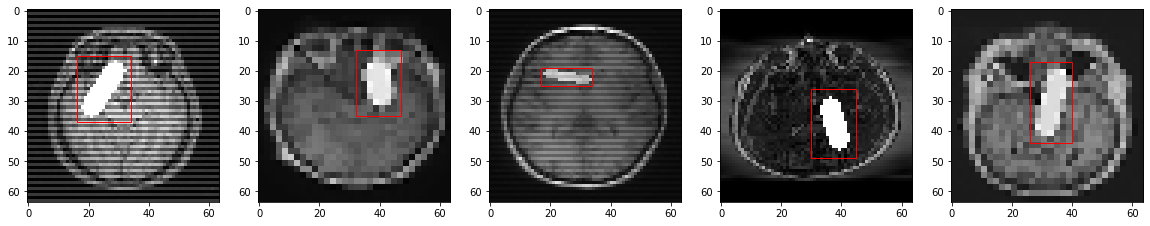

Epoch 1/10
70992/70992 [==============================] - 3090s 44ms/step - loss: 3.2030e-05 - val_loss: 5.0285e-05

Epoch 00001: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_01__.h5
Reconstruction of Test Images: epoch 0


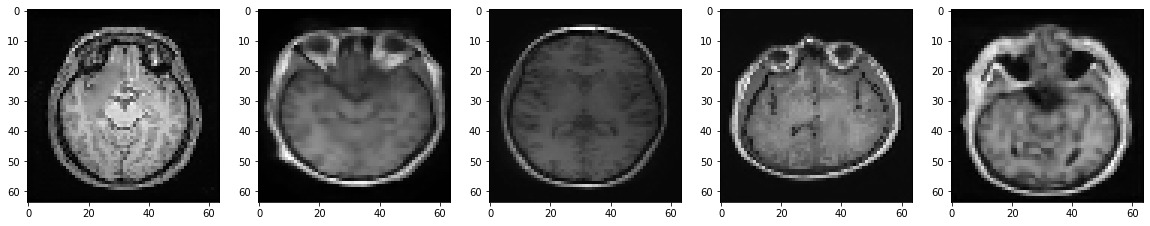

PSNR pictures: 49.215529314893985
MSE pictures 2.305282374918176e-06
SSIM pictures 0.8978922334527414
PSNR patches: 42.79117298124215
MSE patches 1.664126268081957e-05
SSIM patches 0.6131359506084665
Epoch 2/10
70992/70992 [==============================] - 3076s 43ms/step - loss: 3.1171e-05 - val_loss: 5.2173e-05

Epoch 00002: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_02__.h5
Reconstruction of Test Images: epoch 1


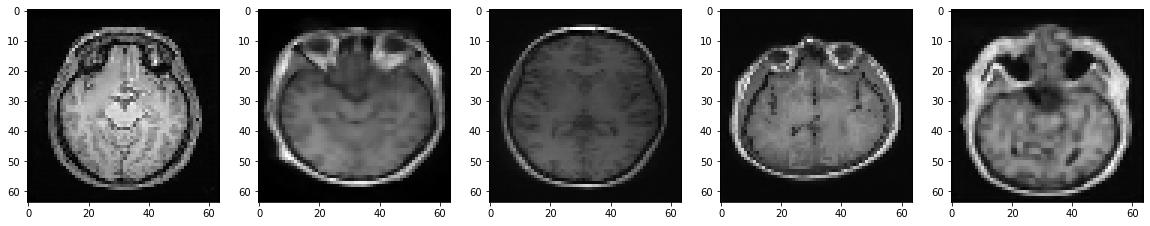

PSNR pictures: 48.59162609348682
MSE pictures 3.396512227015447e-06
SSIM pictures 0.8977591919347899
PSNR patches: 43.158354577821086
MSE patches 1.9128327380365175e-05
SSIM patches 0.6258317538823026
Epoch 3/10
70992/70992 [==============================] - 3074s 43ms/step - loss: 3.0577e-05 - val_loss: 5.4328e-05

Epoch 00003: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_03__.h5
Reconstruction of Test Images: epoch 2


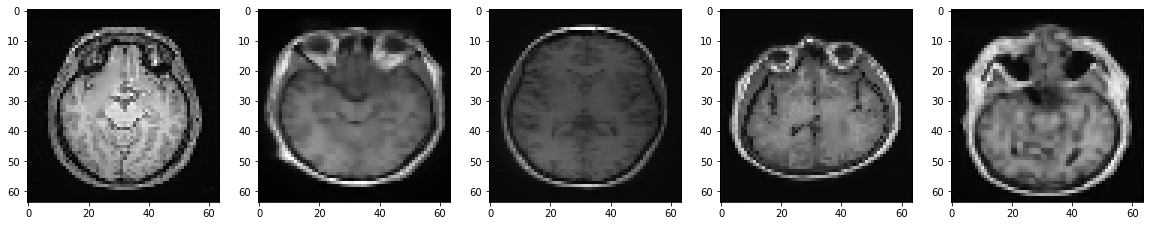

PSNR pictures: 48.64735118367437
MSE pictures 4.619185461980372e-06
SSIM pictures 0.8996909991693797
PSNR patches: 43.02105496340676
MSE patches 1.9120422344674736e-05
SSIM patches 0.6242515924241155
Epoch 4/10
70992/70992 [==============================] - 3222s 45ms/step - loss: 2.9945e-05 - val_loss: 5.0054e-05

Epoch 00004: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_04__.h5
Reconstruction of Test Images: epoch 3


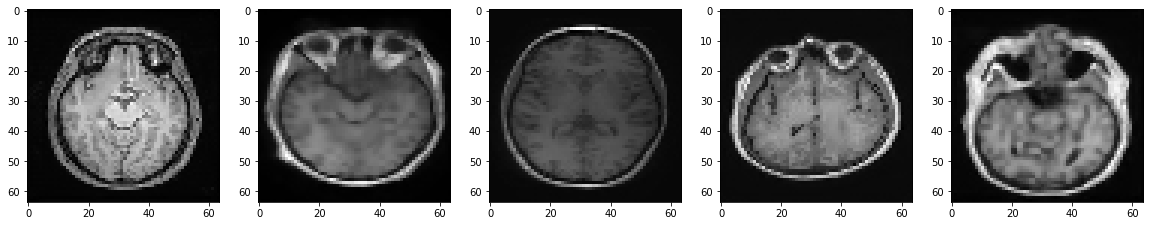

PSNR pictures: 49.43813873156791
MSE pictures 2.450114032714727e-06
SSIM pictures 0.9012618720291746
PSNR patches: 43.37558245396386
MSE patches 1.3435930436221172e-05
SSIM patches 0.6317803449347781
Epoch 5/10
70992/70992 [==============================] - 3525s 50ms/step - loss: 2.9365e-05 - val_loss: 5.1346e-05

Epoch 00005: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_05__.h5
Reconstruction of Test Images: epoch 4


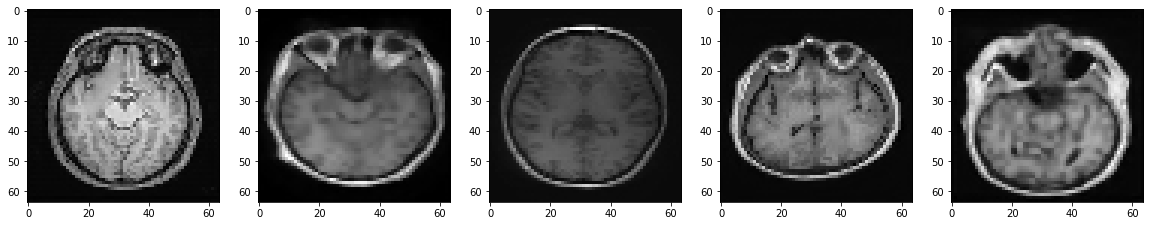

PSNR pictures: 49.20464168130225
MSE pictures 3.1389407583520205e-06
SSIM pictures 0.9006777988540021
PSNR patches: 43.36302930759169
MSE patches 1.665023522924486e-05
SSIM patches 0.6348892028900747
Epoch 6/10
70992/70992 [==============================] - 3531s 50ms/step - loss: 2.9047e-05 - val_loss: 5.0679e-05

Epoch 00006: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_06__.h5
Reconstruction of Test Images: epoch 5


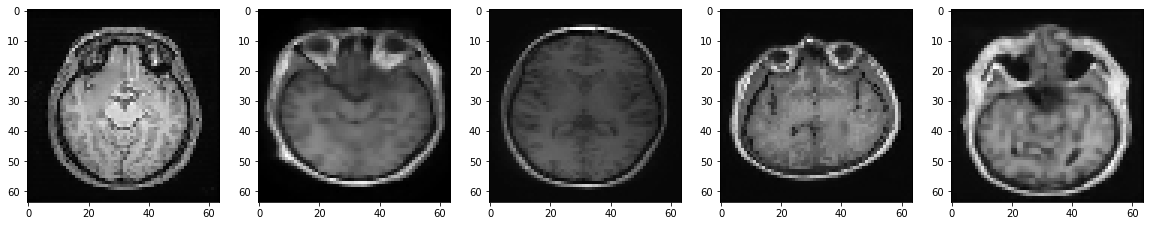

PSNR pictures: 49.49009320915183
MSE pictures 2.6834107315831674e-06
SSIM pictures 0.901136109354447
PSNR patches: 43.337939207160495
MSE patches 1.5904805620096535e-05
SSIM patches 0.6315807357758699
Epoch 7/10
70992/70992 [==============================] - 3530s 50ms/step - loss: 2.8421e-05 - val_loss: 5.0240e-05

Epoch 00007: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_07__.h5
Reconstruction of Test Images: epoch 6


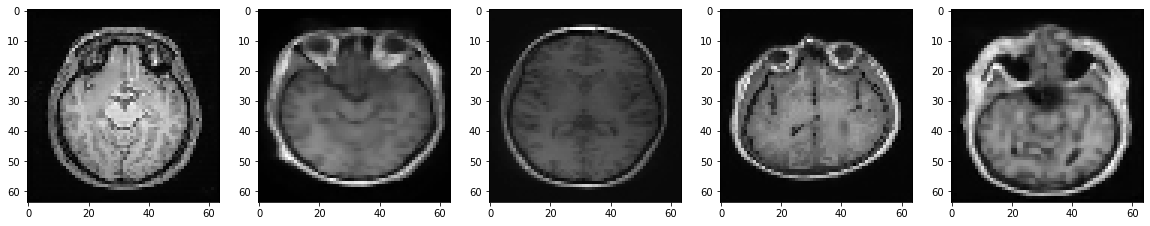

PSNR pictures: 49.55229429136352
MSE pictures 2.608548513860731e-06
SSIM pictures 0.9012432878525046
PSNR patches: 43.40845774445471
MSE patches 1.4481263703513547e-05
SSIM patches 0.6342466184022337
Epoch 8/10
70992/70992 [==============================] - 3524s 50ms/step - loss: 2.7757e-05 - val_loss: 4.8482e-05

Epoch 00008: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_08__.h5
Reconstruction of Test Images: epoch 7


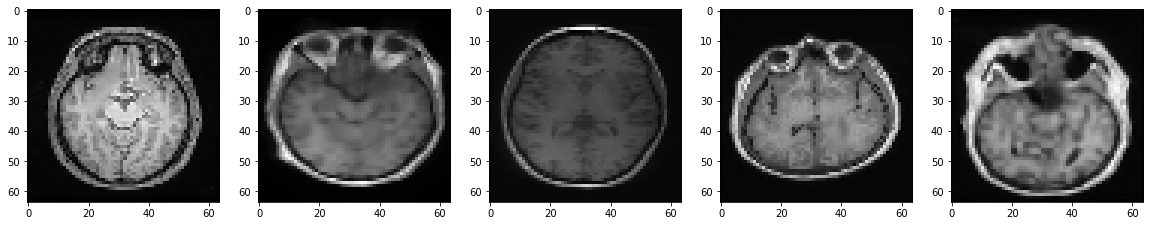

PSNR pictures: 49.93702862787606
MSE pictures 9.140591828512346e-07
SSIM pictures 0.9014800689680086
PSNR patches: 43.62161905086351
MSE patches 8.966042586457916e-06
SSIM patches 0.6374310431751169
Epoch 9/10
70992/70992 [==============================] - 3531s 50ms/step - loss: 2.7099e-05 - val_loss: 5.1854e-05

Epoch 00009: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_09__.h5
Reconstruction of Test Images: epoch 8


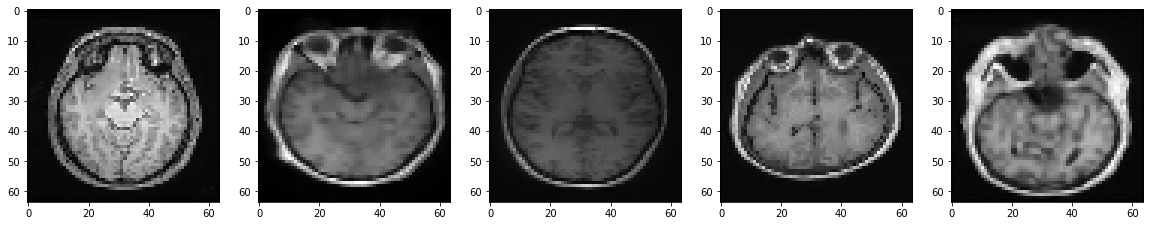

PSNR pictures: 49.37108660270386
MSE pictures 3.214818865643217e-06
SSIM pictures 0.9007161719262688
PSNR patches: 43.37796764220616
MSE patches 1.7189309747710822e-05
SSIM patches 0.6372748925170164
Epoch 10/10
70992/70992 [==============================] - 3524s 50ms/step - loss: 2.6676e-05 - val_loss: 5.2604e-05

Epoch 00010: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_10__.h5
Reconstruction of Test Images: epoch 9


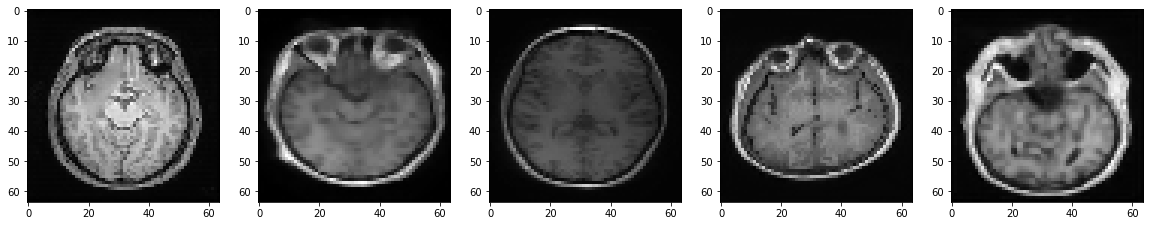

PSNR pictures: 48.850564616035754
MSE pictures 3.346535685771278e-06
SSIM pictures 0.9000880820861678
PSNR patches: 43.243407360227756
MSE patches 1.625824855042084e-05
SSIM patches 0.6347647730819642
Original Images


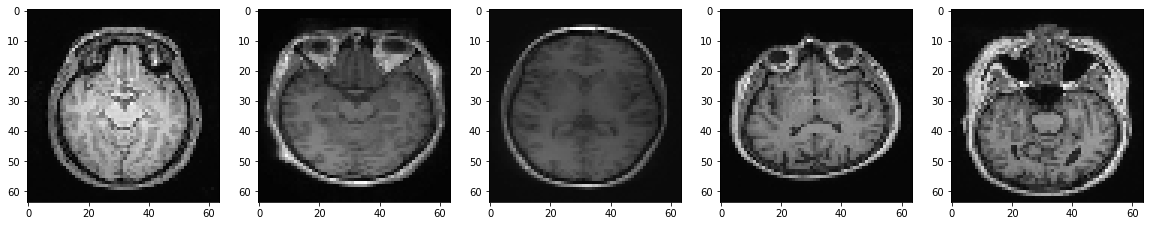

Difference


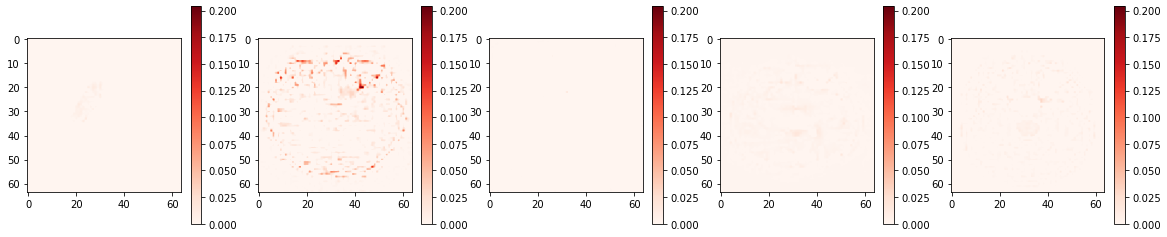

In [36]:
# Train the model
history = model.fit(train_masked, train_original, validation_data=(test_masked, test_original), epochs=10, batch_size=8, verbose=1, callbacks=[model_checkpoint,show_result_Callback()])

Train on 70992 samples, validate on 17901 samples
Test Images


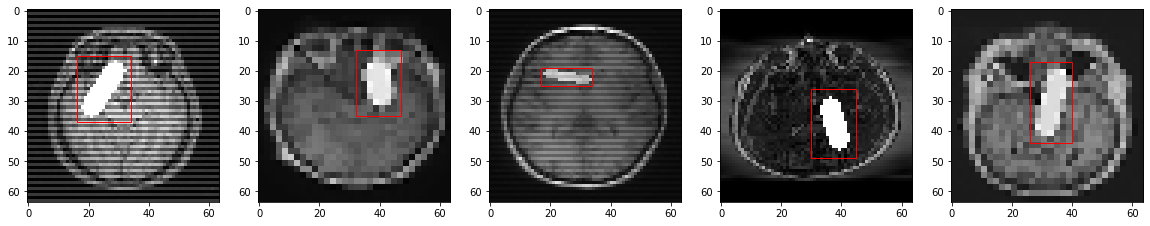

Epoch 1/10
70992/70992 [==============================] - 3528s 50ms/step - loss: 2.6308e-05 - val_loss: 5.5297e-05

Epoch 00001: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_01__.h5
Reconstruction of Test Images: epoch 0


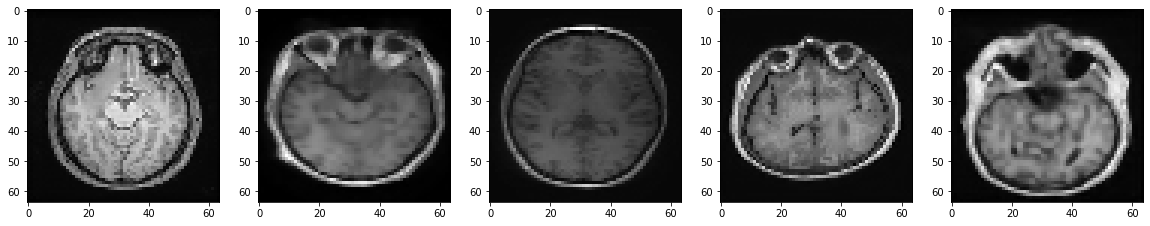

PSNR pictures: 49.277045804282224
MSE pictures 5.768947368669936e-06
SSIM pictures 0.9008737419663393
PSNR patches: 43.18202888353078
MSE patches 2.54160657415746e-05
SSIM patches 0.640353129381363
Epoch 2/10
70992/70992 [==============================] - 3528s 50ms/step - loss: 2.5660e-05 - val_loss: 4.9030e-05

Epoch 00002: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_02__.h5
Reconstruction of Test Images: epoch 1


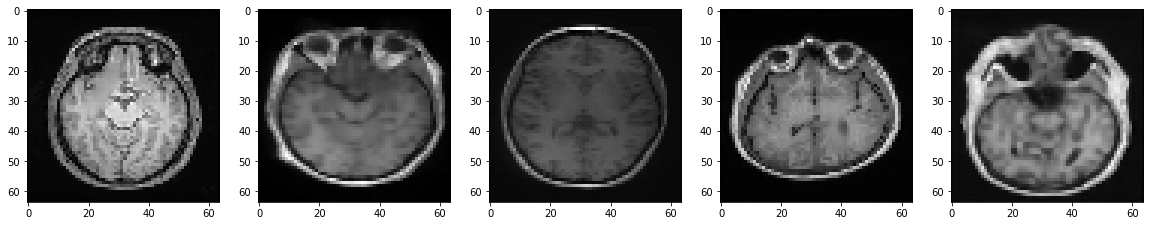

PSNR pictures: 50.00686822914738
MSE pictures 8.234104116592014e-07
SSIM pictures 0.9028328773962533
PSNR patches: 43.61417750747414
MSE patches 9.458478010098043e-06
SSIM patches 0.6425536474434675
Epoch 3/10
70992/70992 [==============================] - 3522s 50ms/step - loss: 2.5239e-05 - val_loss: 5.0782e-05

Epoch 00003: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_03__.h5
Reconstruction of Test Images: epoch 2


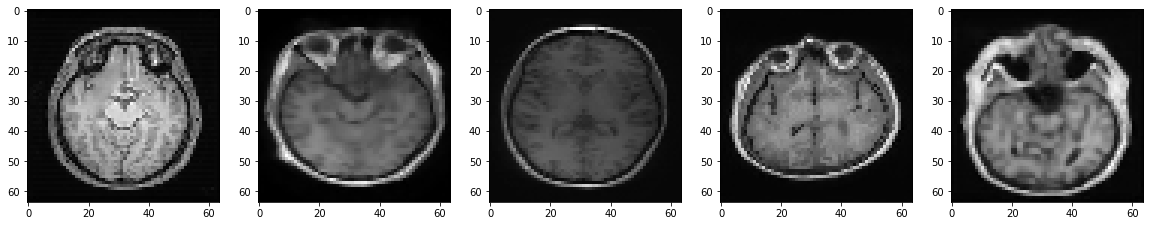

PSNR pictures: 49.56146297202491
MSE pictures 2.5192380682991877e-06
SSIM pictures 0.9019821804404567
PSNR patches: 43.44308457107897
MSE patches 1.4377930931188646e-05
SSIM patches 0.6429889481899383
Epoch 4/10
70992/70992 [==============================] - 3524s 50ms/step - loss: 2.5055e-05 - val_loss: 5.1493e-05

Epoch 00004: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_04__.h5
Reconstruction of Test Images: epoch 3


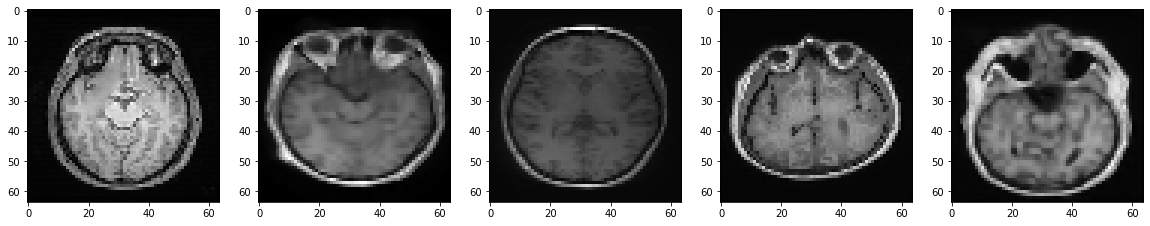

PSNR pictures: 49.1845435808161
MSE pictures 3.0538105382394166e-06
SSIM pictures 0.9032818630824418
PSNR patches: 43.314336766856506
MSE patches 1.4885940392189682e-05
SSIM patches 0.642629668569515
Epoch 5/10
70992/70992 [==============================] - 3531s 50ms/step - loss: 2.4581e-05 - val_loss: 5.2742e-05

Epoch 00005: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_05__.h5
Reconstruction of Test Images: epoch 4


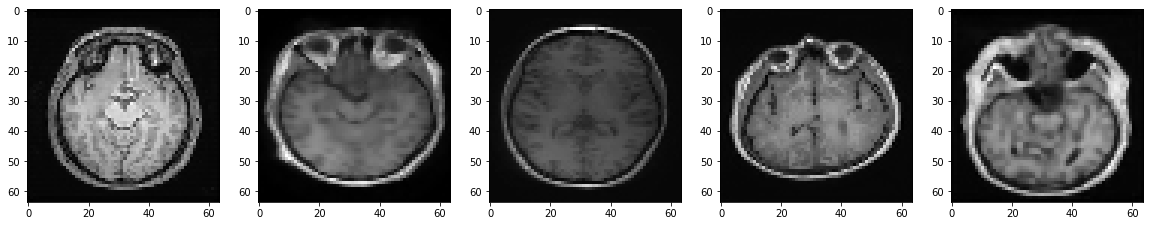

PSNR pictures: 49.626337546907244
MSE pictures 3.485524738772031e-06
SSIM pictures 0.9023914948632961
PSNR patches: 43.41564749549179
MSE patches 1.9549408069439247e-05
SSIM patches 0.6437291601711695
Epoch 6/10
70992/70992 [==============================] - 3529s 50ms/step - loss: 2.4308e-05 - val_loss: 5.1464e-05

Epoch 00006: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_06__.h5
Reconstruction of Test Images: epoch 5


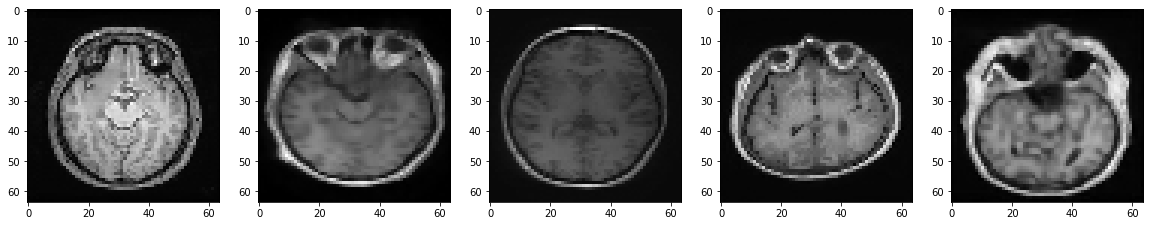

PSNR pictures: 49.74899225758918
MSE pictures 2.6504614975101703e-06
SSIM pictures 0.9028768080146312
PSNR patches: 43.52598980709487
MSE patches 1.575378680631428e-05
SSIM patches 0.6463236864529612
Epoch 7/10
70992/70992 [==============================] - 3524s 50ms/step - loss: 2.3797e-05 - val_loss: 5.1758e-05

Epoch 00007: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_07__.h5
Reconstruction of Test Images: epoch 6


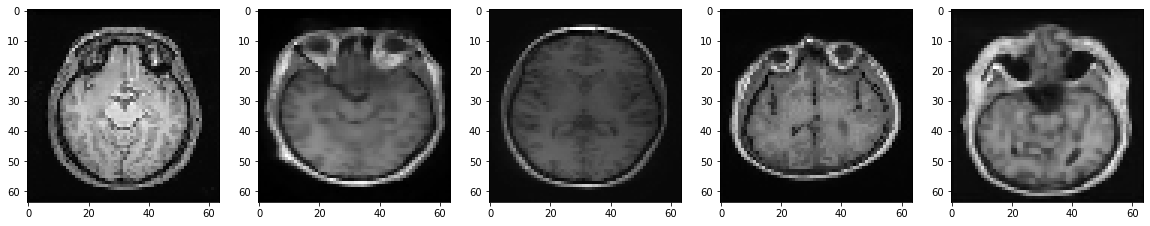

PSNR pictures: 49.682843551218525
MSE pictures 2.822555448922503e-06
SSIM pictures 0.9029564251573218
PSNR patches: 43.524125985460515
MSE patches 1.4294431511019065e-05
SSIM patches 0.646310286523853
Epoch 8/10
70992/70992 [==============================] - 3523s 50ms/step - loss: 2.3389e-05 - val_loss: 4.9793e-05

Epoch 00008: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_08__.h5
Reconstruction of Test Images: epoch 7


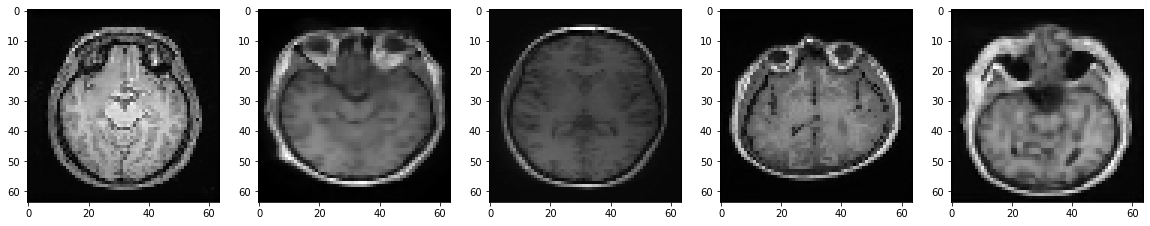

PSNR pictures: 49.96999346232791
MSE pictures 1.4106607760395455e-06
SSIM pictures 0.9037382997689553
PSNR patches: 43.664805305650845
MSE patches 1.0443120831183956e-05
SSIM patches 0.647387440432952
Epoch 9/10
70992/70992 [==============================] - 3522s 50ms/step - loss: 2.3339e-05 - val_loss: 5.1671e-05

Epoch 00009: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_09__.h5
Reconstruction of Test Images: epoch 8


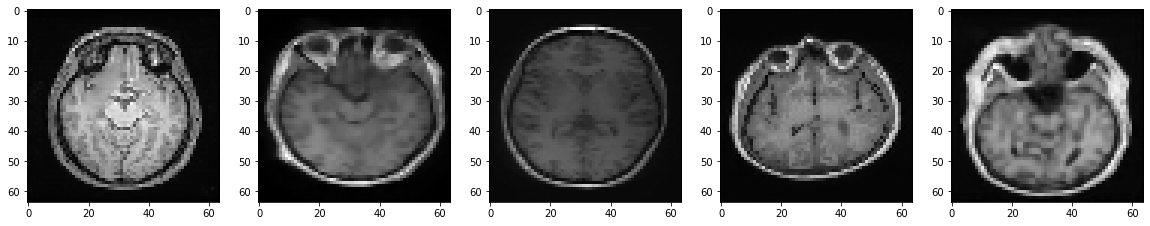

PSNR pictures: 49.75769350318023
MSE pictures 2.7520596297556363e-06
SSIM pictures 0.9032256590338914
PSNR patches: 43.45459789411161
MSE patches 1.7160192331555177e-05
SSIM patches 0.6452239146068736
Epoch 10/10
70992/70992 [==============================] - 3291s 46ms/step - loss: 2.2794e-05 - val_loss: 5.2078e-05

Epoch 00010: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_10__.h5
Reconstruction of Test Images: epoch 9


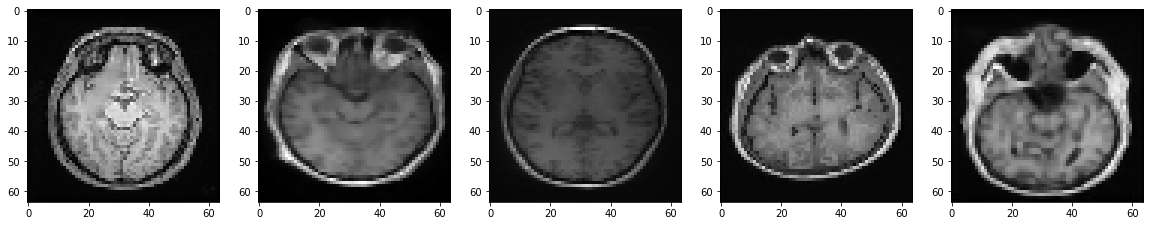

PSNR pictures: 49.819025366763576
MSE pictures 3.087823737953542e-06
SSIM pictures 0.9036465638671052
PSNR patches: 43.49931047988605
MSE patches 1.6080189323302544e-05
SSIM patches 0.6491529878373865
Original Images


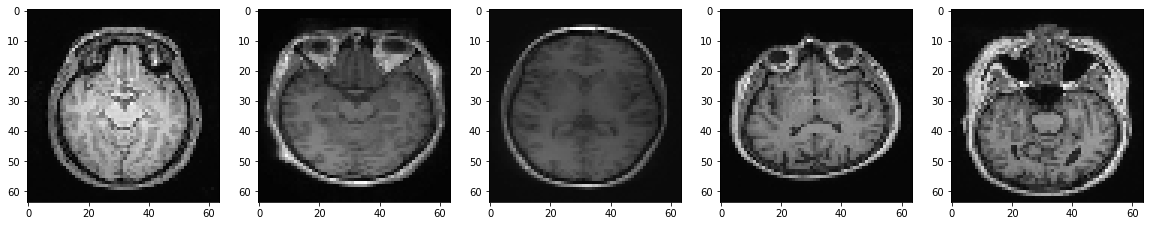

Difference


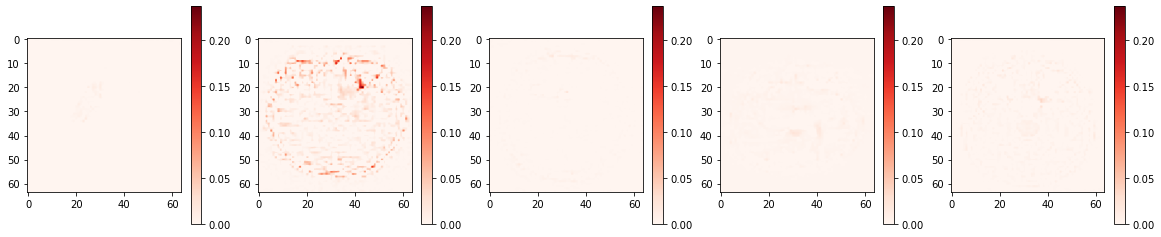

In [38]:
history = model.fit(train_masked, train_original, validation_data=(test_masked, test_original), epochs=10, batch_size=8, verbose=1, callbacks=[model_checkpoint,show_result_Callback()])

Train on 70992 samples, validate on 17901 samples
Test Images


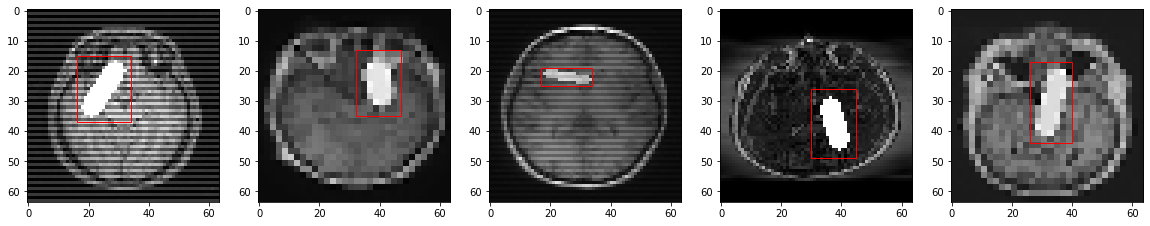

Epoch 1/10
70992/70992 [==============================] - 3074s 43ms/step - loss: 2.3107e-05 - val_loss: 5.0844e-05

Epoch 00001: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_01___.h5
Reconstruction of Test Images: epoch 0


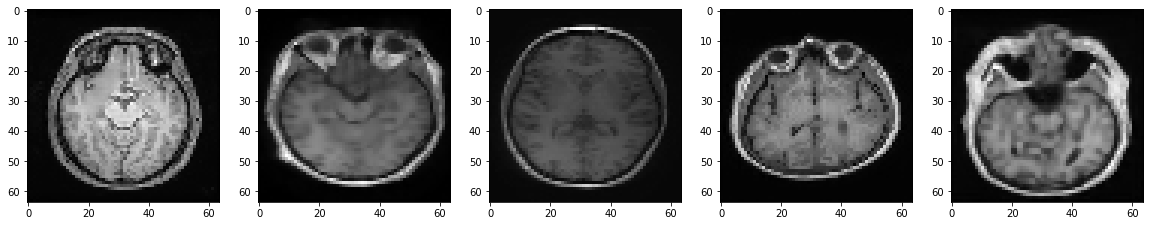

PSNR pictures: 49.911870508842306
MSE pictures 2.0818117850109293e-06
SSIM pictures 0.9043694329182554
PSNR patches: 43.6394223277149
MSE patches 1.3782563947945945e-05
SSIM patches 0.6504210200622372
Epoch 2/10
70992/70992 [==============================] - 3072s 43ms/step - loss: 2.2324e-05 - val_loss: 5.2045e-05

Epoch 00002: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_02___.h5
Reconstruction of Test Images: epoch 1


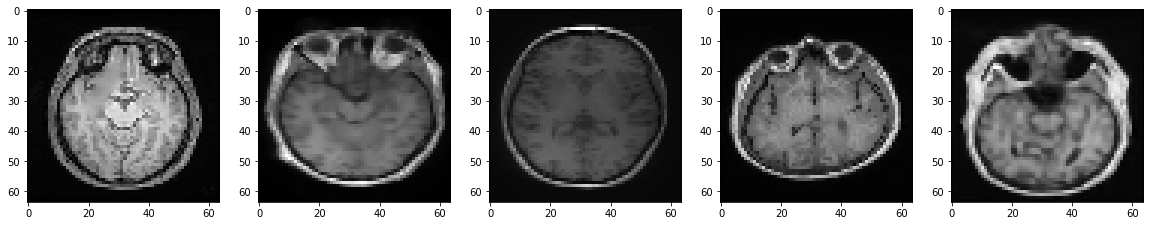

PSNR pictures: 49.7717567693989
MSE pictures 2.6089439721642918e-06
SSIM pictures 0.9042060831850968
PSNR patches: 43.44252301347477
MSE patches 1.5983860930908845e-05
SSIM patches 0.6486275998929777
Epoch 3/10
70992/70992 [==============================] - 3081s 43ms/step - loss: 2.2103e-05 - val_loss: 5.1998e-05

Epoch 00003: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_03___.h5
Reconstruction of Test Images: epoch 2


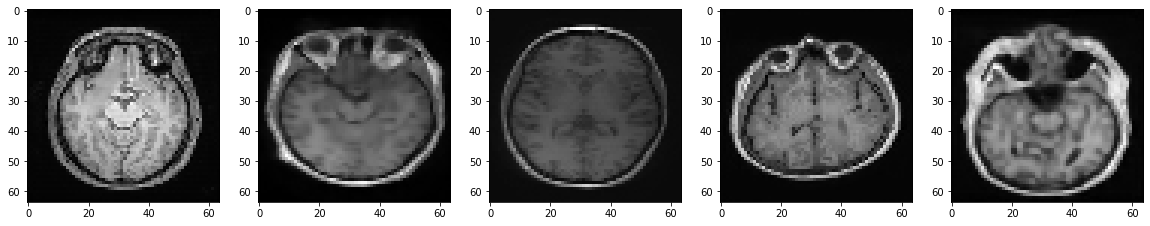

PSNR pictures: 48.86615501738639
MSE pictures 3.214653720283304e-06
SSIM pictures 0.9044982534311039
PSNR patches: 43.439194805838184
MSE patches 1.4890751204405331e-05
SSIM patches 0.6501902910145704
Epoch 4/10
70992/70992 [==============================] - 3081s 43ms/step - loss: 2.1748e-05 - val_loss: 5.0738e-05

Epoch 00004: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_04___.h5
Reconstruction of Test Images: epoch 3


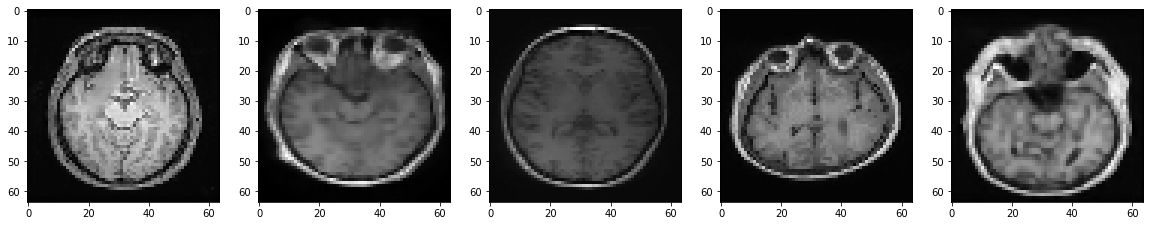

PSNR pictures: 49.703902078893044
MSE pictures 1.8377217798779356e-06
SSIM pictures 0.9040214522089784
PSNR patches: 43.620130624817776
MSE patches 1.2057805405161636e-05
SSIM patches 0.6521243810539707
Epoch 5/10
70992/70992 [==============================] - 3073s 43ms/step - loss: 2.1727e-05 - val_loss: 5.1437e-05

Epoch 00005: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_05___.h5
Reconstruction of Test Images: epoch 4


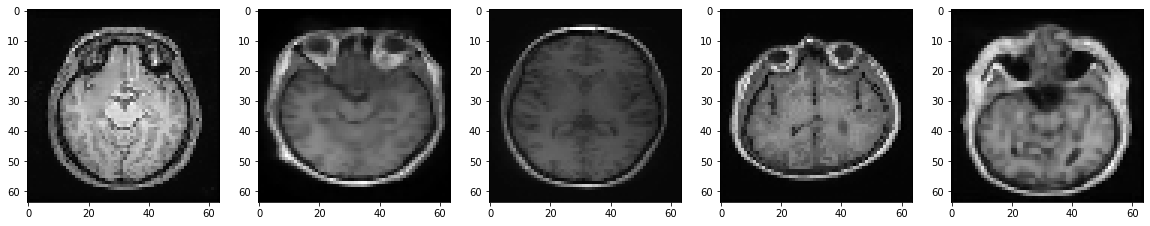

PSNR pictures: 49.89225080750778
MSE pictures 2.459347880586311e-06
SSIM pictures 0.903756633716062
PSNR patches: 43.509786124540895
MSE patches 1.5240460642503808e-05
SSIM patches 0.648994715818528
Epoch 6/10
70992/70992 [==============================] - 3084s 43ms/step - loss: 2.1261e-05 - val_loss: 5.1555e-05

Epoch 00006: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_06___.h5
Reconstruction of Test Images: epoch 5


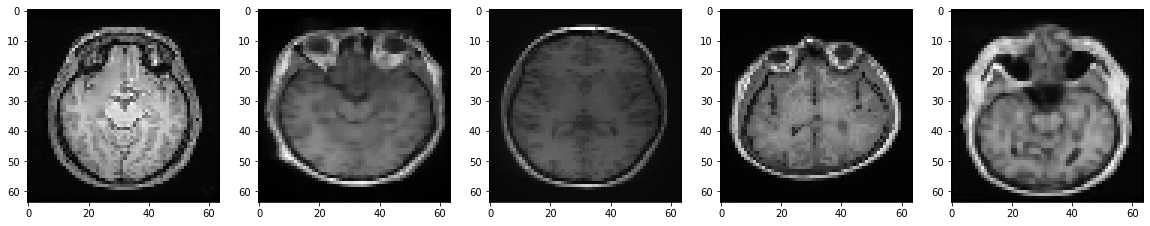

PSNR pictures: 49.79617035764842
MSE pictures 2.364477889266489e-06
SSIM pictures 0.9041517793667508
PSNR patches: 43.61123166959715
MSE patches 1.3810117640294865e-05
SSIM patches 0.6513680415767155
Epoch 7/10
70992/70992 [==============================] - 3553s 50ms/step - loss: 2.0957e-05 - val_loss: 5.1295e-05

Epoch 00007: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_07___.h5
Reconstruction of Test Images: epoch 6


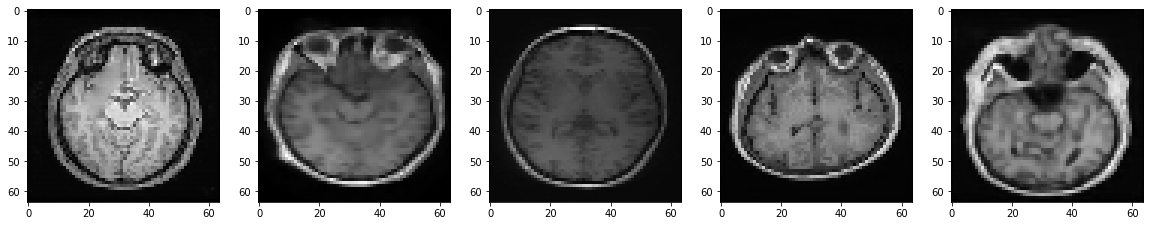

PSNR pictures: 49.8566047235777
MSE pictures 2.3871284116666673e-06
SSIM pictures 0.9048705992012133
PSNR patches: 43.624575037311374
MSE patches 1.4605198699797806e-05
SSIM patches 0.6537725250758771
Epoch 8/10
70992/70992 [==============================] - 3526s 50ms/step - loss: 2.0844e-05 - val_loss: 5.2432e-05

Epoch 00008: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_08___.h5
Reconstruction of Test Images: epoch 7


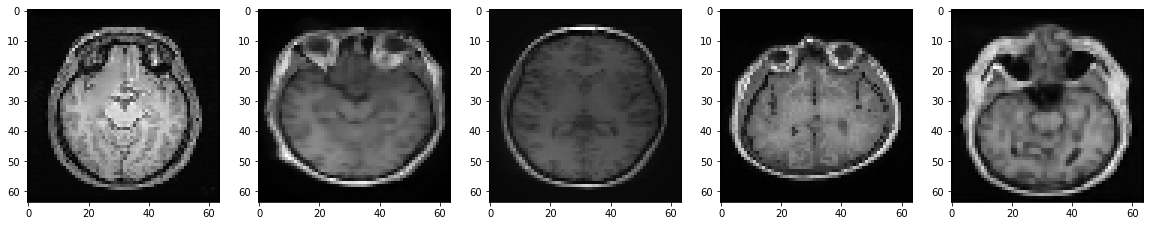

PSNR pictures: 49.465913903988316
MSE pictures 2.8062929489512734e-06
SSIM pictures 0.9029230760756938
PSNR patches: 43.57506725645405
MSE patches 1.568308654559093e-05
SSIM patches 0.6497653332827542
Epoch 9/10
70992/70992 [==============================] - 3525s 50ms/step - loss: 2.0643e-05 - val_loss: 5.2566e-05

Epoch 00009: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_09___.h5
Reconstruction of Test Images: epoch 8


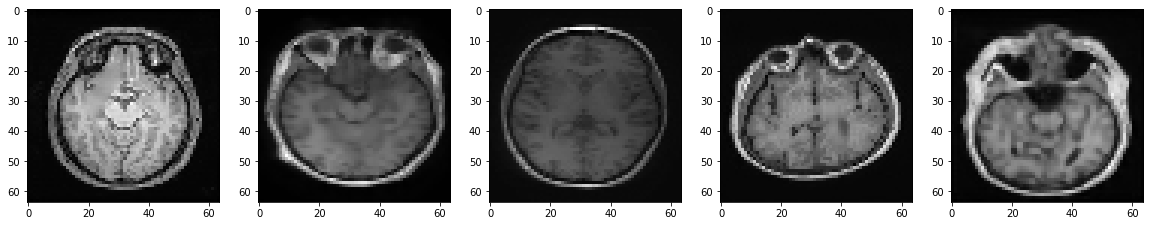

PSNR pictures: 49.87117775255688
MSE pictures 2.9879058951817298e-06
SSIM pictures 0.9037691248464623
PSNR patches: 43.53722093355087
MSE patches 1.67113998296966e-05
SSIM patches 0.652055767552689
Epoch 10/10
70992/70992 [==============================] - 3525s 50ms/step - loss: 2.0513e-05 - val_loss: 5.2307e-05

Epoch 00010: saving model to /Users/fran/Downloads/unet_augmented_32_amd_top_50_10___.h5
Reconstruction of Test Images: epoch 9


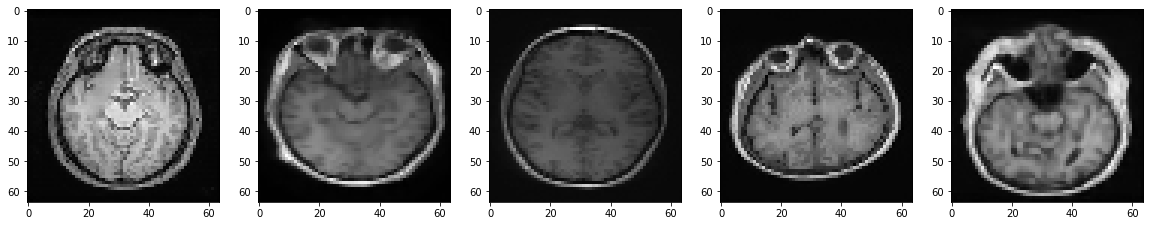

PSNR pictures: 49.800299685540125
MSE pictures 2.4855115944242336e-06
SSIM pictures 0.9053548899901288
PSNR patches: 43.623202091402206
MSE patches 1.4359565555178008e-05
SSIM patches 0.6547741274102867
Original Images


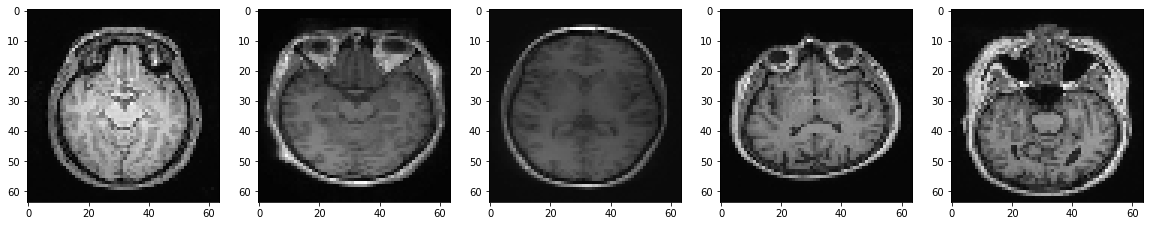

Difference


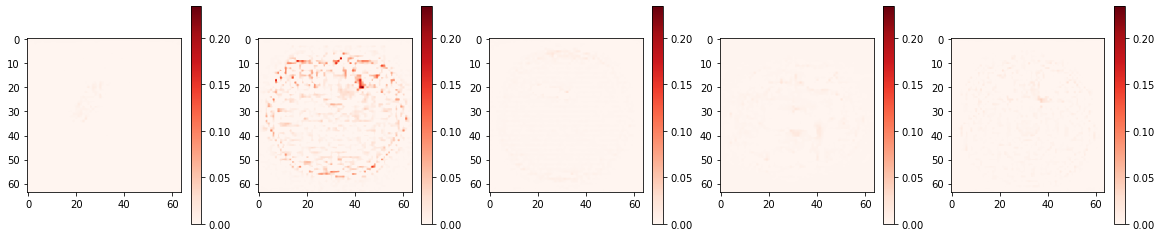

In [41]:
history = model.fit(train_masked, train_original, validation_data=(test_masked, test_original), epochs=10, batch_size=8, verbose=1, callbacks=[model_checkpoint,show_result_Callback()])

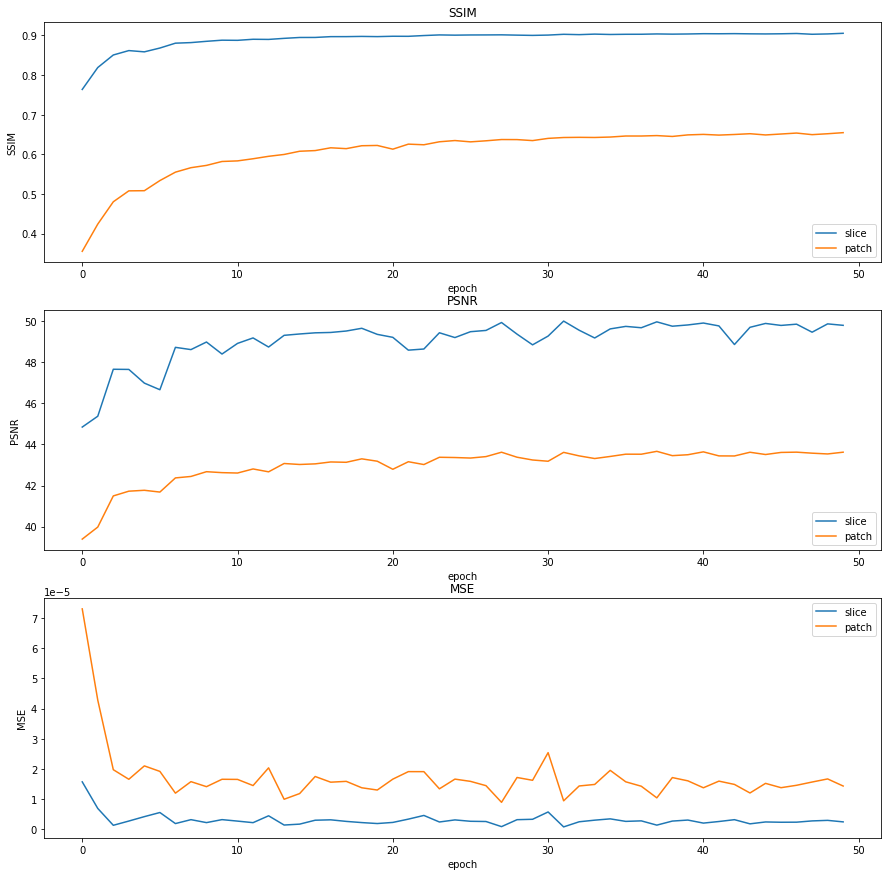

In [42]:
# Results of the training
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(15,15)

# Plot ssim
ax1.plot(ssim_result)
ax1.plot(ssimp_result)
ax1.set_title('SSIM')
ax1.set_ylabel('SSIM')
ax1.set_xlabel('epoch')
ax1.legend(['slice', 'patch'], loc='lower right')

# Plot psnr
ax2.plot(psnr_result)
ax2.plot(psnrp_result)
ax2.set_title('PSNR')
ax2.set_ylabel('PSNR')
ax2.set_xlabel('epoch')
ax2.legend(['slice', 'patch'], loc='lower right')

# Plot mse
ax3.plot(mse_result)
ax3.plot(msep_result)
ax3.set_title('MSE')
ax3.set_ylabel('MSE')
ax3.set_xlabel('epoch')
ax3.legend(['slice', 'patch'], loc='upper right')

Test Images


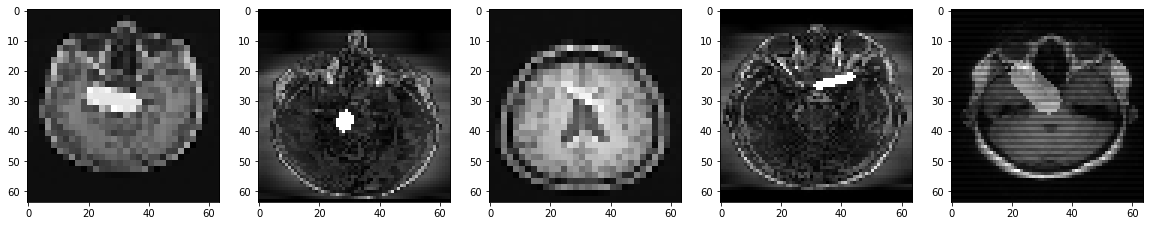

Reconstruction of Test Images


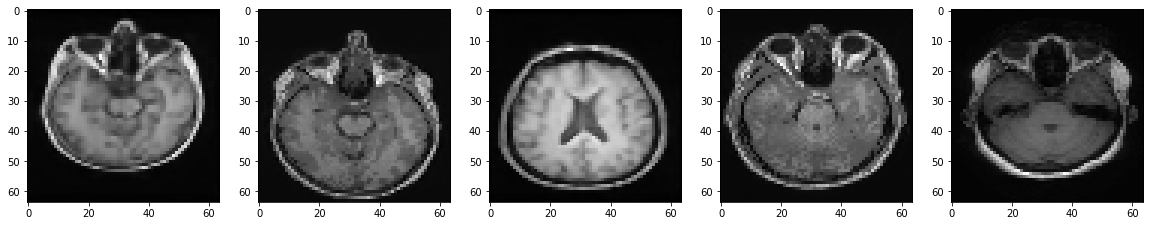

Original Images


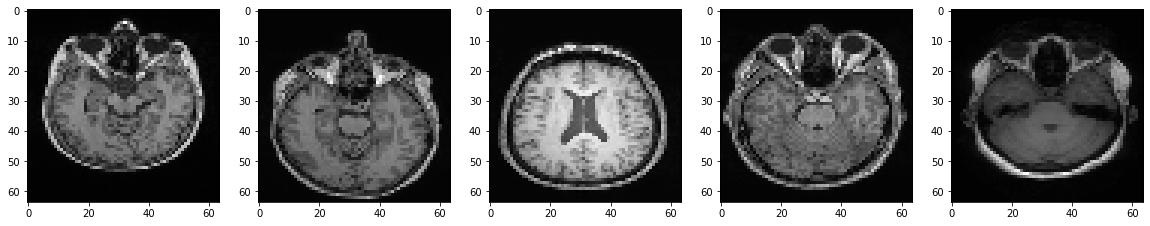

Difference


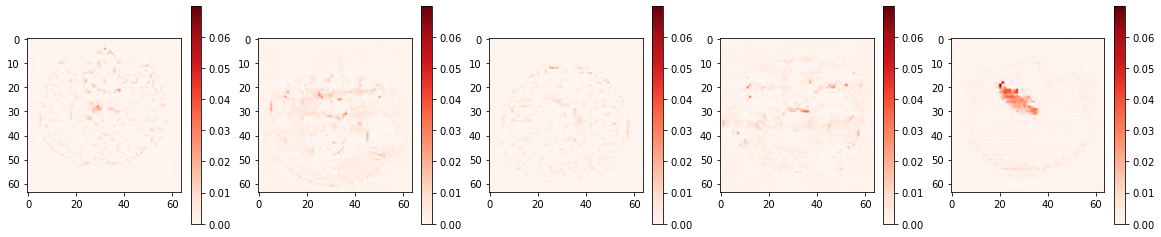

PSNR pictures: 48.43097666107146
MSE pictures: 1.186795859142128e-06
SSIM pictures: 0.8888610349506912


In [45]:
#Show some other results
b=51 # first picture to show
pred = model.predict(test_masked[b:b+5,:,:]) 
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(test_masked[i+b, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

plt.figure(figsize=(20, 4))
print("Original Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(test_original[i+b, ..., 0], cmap='gray') 
plt.show()

pic_diff = test_original[b:b+5,:,:] - pred

plt.figure(figsize=(20, 4))
print("Difference")
psn=[]
mse=[]
ssi=[]
max_color = np.max(pic_diff)
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pic_diff[i, ..., 0], vmin=0, vmax=max_color, cmap='Reds')
    plt.colorbar()
    i1 = test_original[i+b, ..., 0].reshape(img_size*img_size)
    i2 = pred[i, ..., 0].reshape(img_size*img_size)
    psn.append(cv2.PSNR(np.float32(i1), np.float32(i2), 1))
    mse.append(np.square(np.subtract(i1, i2).mean()))
    ssi.append(ssim(i1, i2, data_range=i2.max() - i2.min()))
    #cv2.absdiff
plt.show()
print("PSNR pictures:",np.average(psn))
print("MSE pictures:", np.average(mse))
print("SSIM pictures:",np.average(ssi))

Test Images


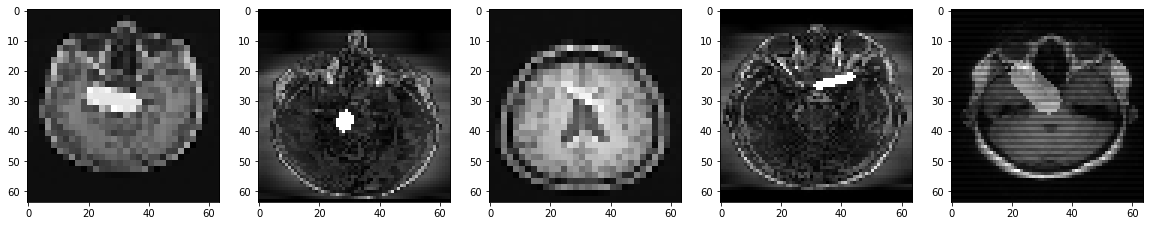

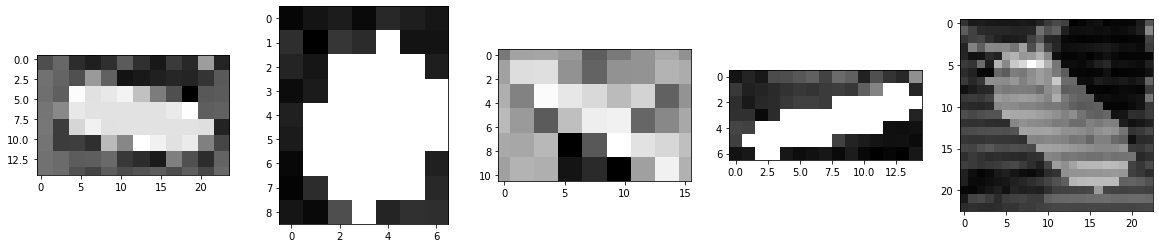

Reconstruction of Test Images


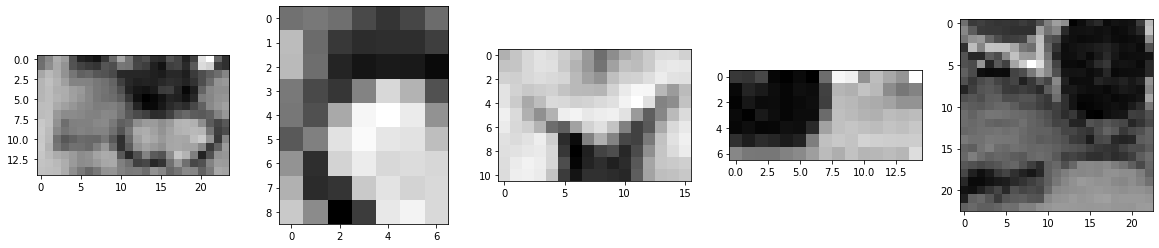

Original Images


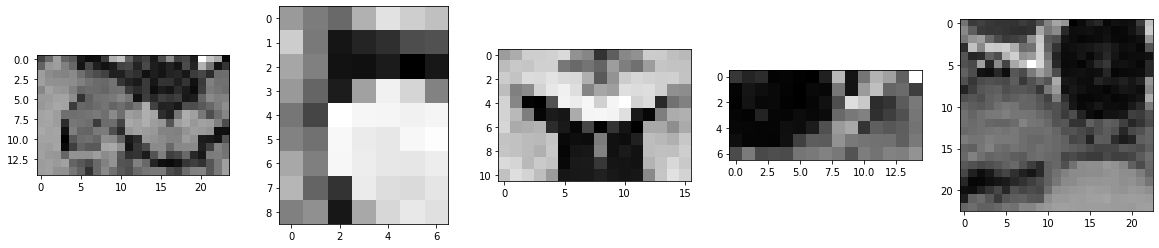

Difference


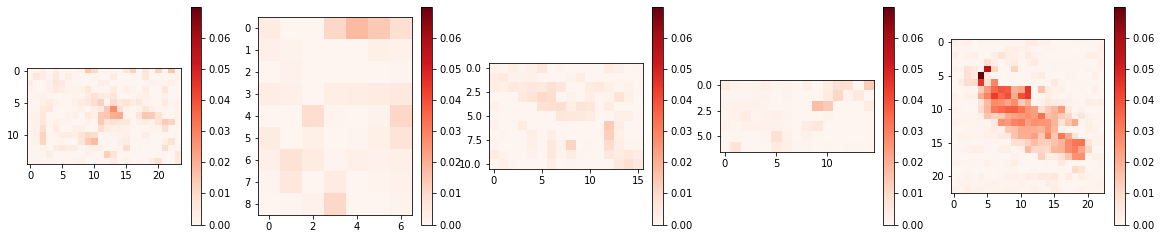

PSNR patches: 43.41482366604411
MSE patches: 5.937875509791742e-06
SSIM patches: 0.7015859644624607


In [46]:
# Show some results for the patches
b=51
pred = model.predict(test_masked[b:b+5,:,:]) 

plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(test_masked[i+b, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
for i in range(5):
    x_start, y_start, x_len, y_len = patch_loc(test_masked_loc,i+b)
    plt.subplot(1, 5, i+1)
    plt.imshow(test_masked[i+b, y_start:y_start+y_len, x_start:x_start+x_len, 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
    x_start, y_start, x_len, y_len = patch_loc(test_masked_loc,i+b)
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i, y_start:y_start+y_len, x_start:x_start+x_len, 0], cmap='gray')
plt.show()

plt.figure(figsize=(20, 4))
print("Original Images")
for i in range(5):
    x_start, y_start, x_len, y_len = patch_loc(test_masked_loc,i+b)
    plt.subplot(1, 5, i+1)
    plt.imshow(test_original[i+b, y_start:y_start+y_len, x_start:x_start+x_len, 0], cmap='gray')
plt.show()

pic_diff = test_original[b:b+5,:,:] - pred

plt.figure(figsize=(20, 4))
print("Difference")
psnp=[]
msep=[]
ssip=[]
max_color = np.max(pic_diff[0:5,:,:])
for i in range(5):
    plt.subplot(1, 5, i+1)
    x_start, y_start, x_len, y_len = patch_loc(test_masked_loc,i+b)
    plt.imshow(pic_diff[i, y_start:y_start+y_len, x_start:x_start+x_len, 0], cmap='Reds', vmin=0, vmax=max_color)
    plt.colorbar()
    i1 = test_original[i+b, y_start:y_start+y_len, x_start:x_start+x_len, 0].reshape(y_len*x_len)
    i2 = pred[i, y_start:y_start+y_len, x_start:x_start+x_len, 0].reshape(y_len*x_len)
    #cv2.absdiff
    psnp.append(cv2.PSNR(np.float32(i1), np.float32(i2), 1))
    msep.append(np.square(np.subtract(i1, i2).mean()))
    ssip.append(ssim(i1, i2, data_range=i2.max() - i2.min()))
    #cv2.absdiff
plt.show()
print("PSNR patches:",np.average(psnp))
print("MSE patches:", np.average(msep))
print("SSIM patches:",np.average(ssip))